# X-ray detected Be star catalog

**Caden Gobat**<sup>1</sup> & **Hui Yang**<sup>1</sup>

<sup>1</sup>The George Washington University

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, pickle, seaborn as sns, sympy, matplotlib as mpl
from astropy.io import fits, ascii as ascii_io, votable
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
import astropy.coordinates as coord

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.table import Table
from gdpyc import GasMap, DustMap
import mwdust
combined19= mwdust.Combined19()

from scipy import stats, optimize
import math
from collections import Counter
from matplotlib.lines import Line2D

from astropy.table import Table, Column, MaskedColumn

from asymmetric_uncertainty import AsymmetricUncertainty

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Defining some functions 

In [2]:
def find_nearest(df, ind_col='_q', sep_col='_r', check=False, drop=False):
    
    '''
    dropping multiple matches for the source with the same ind_col column by keeping the nearest match of sep_col column
    '''

    print('Before cleaning multiple matches:', len(df), 'rows.')
    df_nearest = pd.DataFrame(columns=[ind_col])
    for i in df[ind_col].unique():
        df_sub = df.loc[df[ind_col]==i]
        instances = len(df_sub)
        if instances == 0:
            pass
        elif drop and i in drop:
            pass
        else:
            if check and instances>1:
                print(df_sub)
                
            df_src = df_sub.loc[df_sub[sep_col] ==min(df_sub[sep_col])]
            if len(df_src)>1:
                df_nearest = pd.concat([df_nearest, df_src.head(1)])
            else:
                df_nearest = pd.concat([df_nearest, df_src])
    print('After cleaning multiple matches:', len(df_nearest), 'rows.')
    return df_nearest

def bandshift(fluxA,bandA,bandB,Gamma=1.7):
    
    '''
    calculating the converted energy fluxes from bandA energy range to bandB energy range assuming a power-law spectrum with photon index Gamma
    '''
    
    a1,a2 = bandA
    b1,b2 = bandB
    if Gamma == 2:
        integral = lambda lower,upper : np.log(upper) - np.log(lower)
    else:
        integral = lambda lower,upper : (upper**(2-Gamma) - lower**(2-Gamma))/(2-Gamma)
    scalar = fluxA/integral(a1,a2)
    fluxB = scalar*integral(b1,b2)
    return fluxB

In [3]:
# Reading the BeSS catalog, obtained from http://basebe.obspm.fr/basebe/

BeSS = ascii_io.read("./catalogs/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'hourangle').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
BeSS.pprint()

 #    Be star    Category ...       _RAJ2000            _DEJ2000     
                          ...         deg                 deg        
---- ---------- --------- ... ------------------- -------------------
   1 BD+62 2346 Classical ... 0.35291666666666666   63.50436944444444
   2  HD 224905 Classical ... 0.41095833333333326   60.44992222222222
   3  HD 225095 Classical ...  0.8631249999999999   55.55089722222222
   4      2 Cet Classical ...  0.9349583333333332 -17.335991666666665
   5     10 Cas Classical ...  1.6105833333333333   64.19616944444445
   6 BD+59 2829 Classical ...  1.7012499999999997  60.600230555555555
 ...        ...       ... ...                 ...                 ...
2258   V818 Cas Classical ...   357.4713333333333   62.21409166666667
2259 EM* AS 518 Classical ...  359.38362499999994   72.88435833333334
2260 BD+65 1970 Classical ...   359.3920833333333   66.43162222222223
2261     LQ And Classical ...   359.6934999999999  46.413177777777776
2262  HD 224544 Clas

## Updating optical coordinates of some Be stars after manual investigation, since some Be stars from the BeSS catalog have relatively large positional uncertainties (1"-5")

In [4]:

indexs =    [68,        42,         47,         49,         230,       237,        253,      272,       274,        260,      296,     1630]

gaia_ras =  [13.02345,   12.142170,  12.306773,  12.374212,  14.400078,14.552446,  15.262034,16.290251, 16.480222,  15.467899,19.633210,215.300650]
gaia_decs = [-72.434514, -73.042030, -73.193853, -73.182921, -72.326132,-72.513544,-72.116379,-72.196375,-72.064044,-72.392790,63.742520,-62.698914]


for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    #print(BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'])
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'] = ra, dec 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])
    
BeSS['conf_flag'] = 0

indexs =    [760,      767,      150,       215,            516,      857,       1410,           1478,      1604,          2074,      189,          1715,      1930,      139,      1375,            857,            1475,             79,          120,         226,              265,                   1243,           1331,        1574,     1926]

gaia_ras =  [80.124405,80.691452,13.95320073136, 14.16150651198, 34.809579,83.920304, 165.62489467958,174.7414595,207.402686,   303.73052859,14.08276055767,241.011158,274.692197,13.896433, 161.47374583153,83.92084433997, 174.58301532056,13.34460251277,13.72732352852,14.29036126271,15.9064071959,       133.34164824874,156.50072742424,198.54794100157,274.63838149679]
gaia_decs = [-69.532146,33.416338,-72.45357585484,-72.30366663757,57.184698,-66.864928,-60.81551722574,-63.4774941368,-42.473011,36.8535390968,-72.46714301601,-47.477649,-13.910324,-72.485176, -59.95105371342,-66.86487936541,-63.34347837499,-72.19883641895,-72.45661959811,-72.44935286279,-72.02589539658,-46.03576523452,-57.82691748014,-63.37375307540,-13.75223648534]

for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'], BeSS[ind]['conf_flag'] = ra, dec, 2 
    # those are questionable matches confirmed later 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])



       Be star         _RAJ2000  _DEJ2000 
                         deg       deg    
--------------------- --------- ----------
            X SMC X-3  13.02345 -72.434514
      RX J0048.5-7302  12.14217  -73.04203
      RX J0049.2-7311 12.306773 -73.193853
      RX J0049.5-7310 12.374212 -73.182921
CXOU J005736.2-721934 14.400078 -72.326132
      RX J0058.2-7231 14.552446 -72.513544
      RX J0101.0-7206 15.262034 -72.116379
      RX J0105.3-7210 16.290251 -72.196375
      RX J0105.9-7203 16.480222 -72.064044
      RX J0101.8-7223 15.467899  -72.39279
            CAS GAM-1  19.63321   63.74252
           4U 1416-62 215.30065 -62.698914
       Be star             _RAJ2000        _DEJ2000   
                             deg             deg      
---------------------- --------------- ---------------
            [HP99] 946       80.124405      -69.532146
 Cl* NGC 1893 CUF 3104       80.691452       33.416338
      Cl* NGC 330 G 68  13.95320073136 -72.45357585484
Cl* NGC 330 ELS 004509  1

## Cross-matching to Gaia DR3 and Gaia eDR3 distance catalogs using 2"

In [5]:
v = Vizier(columns=['all','_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

print('matching BeSS to gaiadr3')

Gaiadr3_BeSS_2as = v.query_region(BeSS, catalog="I/355/gaiadr3", radius="2s")
df = Gaiadr3_BeSS_2as[0].to_pandas()
Gaiadr3_matched = Gaiadr3_BeSS_2as[0]["_q","_r","Source","RA_ICRS","DE_ICRS","DR3Name","Plx","e_Plx","RPlx","PM","pmRA","e_pmRA","pmDE","e_pmDE","epsi","sepsi","RUWE","Gmag","e_Gmag","BPmag","e_BPmag","RPmag","e_RPmag","Teff"]
Gaiadr3_matched['Source'] = Gaiadr3_matched['Source'].astype(str)
df_gaiadr3 = Gaiadr3_matched.to_pandas()
df_gaiadr3 = df_gaiadr3.dropna(subset=['_r'])

# Removing Be stars that are matched to the same Gaia eDR3 sources, 
# those are mostly duplicated Be stars that have slightly different coordinates 
df_gaiadr3 = find_nearest(df_gaiadr3, ind_col='Source', sep_col='_r', check=False, drop=False)


print('matching to gaiadr3paramp to get the physical parameters (e.g., spectral types)')

Gaiaparamp_BeSS_2as = v.query_region(BeSS, catalog="I/355/paramp", radius="2s")
Gaiaparamp_matched = Gaiaparamp_BeSS_2as[0]["_q","_r","Source","Pstar","SpType-ELS"]
Gaiaparamp_matched['Source'] = Gaiaparamp_matched['Source'].astype(str)
df_gaiaparamp = Gaiaparamp_matched.to_pandas()

df_gaiaparamp = find_nearest(df_gaiaparamp, ind_col='Source', sep_col='_r', check=False, drop=False)


print('matching to gaiaedr3dist to get the distance info')

Gaiadist_BeSS_2as = v.query_region(BeSS, catalog="I/352/gedr3dis", radius="2s")
Gaiadist_matched = Gaiadist_BeSS_2as[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo"]#,"Flag"]
Gaiadist_matched['Source'] = Gaiadist_matched['Source'].astype(str)
df_gaiadist = Gaiadist_matched.to_pandas()

df_gaiadist = find_nearest(df_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)



matching BeSS to gaiadr3
Before cleaning multiple matches: 2485 rows.
After cleaning multiple matches: 2463 rows.
matching to gaiadr3paramp to get the physical parameters (e.g., spectral types)
Before cleaning multiple matches: 2235 rows.
After cleaning multiple matches: 2210 rows.
matching to gaiaedr3dist to get the distance info
Before cleaning multiple matches: 2327 rows.
After cleaning multiple matches: 2312 rows.


In [6]:
# Combing the matching results from Gaia dr3 and Gaia edr3dist

df_gaia_comb = pd.merge(df_gaiadr3, df_gaiaparamp, on='Source', how="outer")
df_gaia_comb = pd.merge(df_gaia_comb, df_gaiadist, on='Source', how="outer")
print(len(df_gaia_comb))
df_gaia_comb = df_gaia_comb.rename(columns={'_q':'_q_edr3dist','_r':'_r_edr3dist','_q_x':'_q','_r_x':'_r','_q_y':'_q_dr3par','_r_y':'_r_dr3par'})


# Calculating color BP-RP and absolute magnitude of BPmag

df_gaia_comb['BP-RP'] = df_gaia_comb['BPmag']-df_gaia_comb['RPmag']
df_gaia_comb['abs_BPmag'] = df_gaia_comb['BPmag']-5*(np.log10(df_gaia_comb['rgeo'])-1)

print(df_gaia_comb.columns)

print('The break down of Gaia dr3paramp spectral types:\n', Counter(df_gaia_comb['SpType-ELS']))

2463
Index(['Source', '_q', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name', 'Plx', 'e_Plx',
       'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'sepsi',
       'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag',
       'Teff', '_q_dr3par', '_r_dr3par', 'Pstar', 'SpType-ELS', '_q_edr3dist',
       '_r_edr3dist', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo',
       'B_rpgeo', 'BP-RP', 'abs_BPmag'],
      dtype='object')
The break down of Gaia dr3paramp spectral types:
 Counter({'B': 1570, nan: 253, 'O': 214, '': 152, 'G': 135, 'unknown': 61, 'F': 34, 'A': 28, 'K': 10, 'M': 6})


## Cleaning the sources with multiple Gaia matches

In [7]:
df_gaia_comb['gaia_conf'] = 0

# dropping those multiple/unlikely matches with larger separations and no magnitude and distance measurements

num_before = len(df_gaia_comb)
print(f'Before cleaning matching, #: {num_before}')

print('Removing other matches if the nearest match has O or B type spectral class, #:') 

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        
        sep_min = min(df_sub['_r'])
        nearest_type = df_gaia_comb.loc[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] ==sep_min), 'SpType-ELS'].values[0]
        if nearest_type == 'O' or nearest_type == 'B':#.str.isin(['O','B']):
            
            drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] !=sep_min)].index
            #print(df_gaia_comb.loc[drop_idx])
            df_gaia_comb.drop(drop_idx, inplace = True)
            df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+1

num_remove1 = len(df_gaia_comb)
print(num_before-num_remove1)       


print('Removing unlikely matches that are not the nearest matches and they do not have valid absolute magitude and they do not have O or B type spectral class, #:') 

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        #print(df_sub)
        #'''
        sep_min = min(df_sub['_r'])
        drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r'] !=sep_min) & (df_gaia_comb['abs_BPmag'].isnull()) & (df_gaia_comb['SpType-ELS']!='O') & (df_gaia_comb['SpType-ELS']!='B') ].index
        #print(df_gaia_comb.loc[drop_idx])
        if len(drop_idx)>0:
            df_gaia_comb.drop(drop_idx, inplace = True)
            df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+2
        #'''
print(num_remove1-len(df_gaia_comb))

num_mul = 0
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:
        num_mul+= instances-1
        df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf'] = df_gaia_comb.loc[(df_gaia_comb['_q'] == i), 'gaia_conf']+4
        #'''
print(f'There are still {num_mul} Be star with multiple matches.')

Before cleaning matching, #: 2463
Removing other matches if the nearest match has O or B type spectral class, #:
203
Removing unlikely matches that are not the nearest matches and they do not have valid absolute magitude and they do not have O or B type spectral class, #:
70
There are still 26 Be star with multiple matches.


Text(0, 0.5, 'Absolute BPmag')

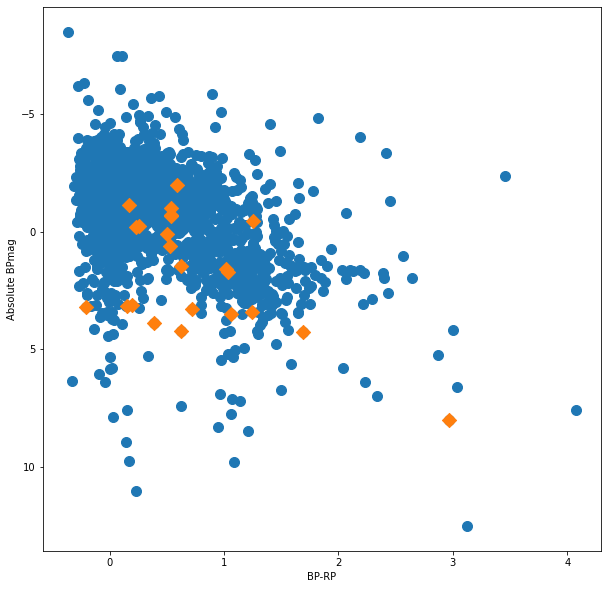

In [8]:
# marking questionable gaia counterparts of BeSS stars with multiple matches using conf_flag_gaia column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(df_gaia_comb['BP-RP'], df_gaia_comb['abs_BPmag'], s=100)

ax.scatter(df_gaia_comb.loc[df_gaia_comb.gaia_conf==4,'BP-RP'], df_gaia_comb.loc[df_gaia_comb.gaia_conf==4,'abs_BPmag'], s=100, marker='D')
'''
j=1
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances == 1:
        pass
    else:
        ax.scatter(df_sub['BP-RP'], df_sub['abs_BPmag'], s=100, marker='D',label=j)
        #print(j, df_sub[['_q','_r_x','Source','_RAJ2000','_DEJ2000','BP-RP','abs_BPmag']])
        j += 1
plt.legend(ncol=2)
'''        
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('Absolute BPmag')

In [9]:
# We take the closest counterparts for those questionable matches with multiple gaia counterparts 
 
df_gaia = find_nearest(df_gaia_comb, ind_col='_q', sep_col='_r')

print(Counter(df_gaia['gaia_conf']))
print(df_gaia.columns)

Before cleaning multiple matches: 2190 rows.
After cleaning multiple matches: 2164 rows.
Counter({0.0: 1941, 1.0: 165, 2.0: 34, 4.0: 15, 6.0: 9})
Index(['_q', 'Source', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name', 'Plx', 'e_Plx',
       'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'sepsi',
       'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag',
       'Teff', '_q_dr3par', '_r_dr3par', 'Pstar', 'SpType-ELS', '_q_edr3dist',
       '_r_edr3dist', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo',
       'B_rpgeo', 'BP-RP', 'abs_BPmag', 'gaia_conf'],
      dtype='object')


In [10]:
# Combining BeSS catalog and gaia catalog 

df_BeSS = BeSS.to_pandas()
#print(df_BeSS.head)
df_comb = pd.merge(df_BeSS[['#','Be star','_RAJ2000', '_DEJ2000','V','Type','vsini','conf_flag']], df_gaia.drop(columns=['_q_dr3par','_r_dr3par','_q_edr3dist', '_r_edr3dist']), left_on="#", right_on="_q", how="outer")
#print(df_comb.columns)

# Using Gaia coordinates rather than BeSS coordinates, unless there is no Gaia match for BeSS stars
print(len(df_comb))
df_comb['RA'], df_comb['DEC'] = df_comb['RA_ICRS'], df_comb['DE_ICRS']
print(len(df_comb[df_comb['RA'].isnull()]))
#print(len(df_comb[df_comb['DEC'].isnull()]))
df_comb.loc[df_comb['RA'].isnull(), 'RA'] = df_comb.loc[df_comb['RA'].isnull(), '_RAJ2000']
df_comb.loc[df_comb['DEC'].isnull(), 'DEC'] = df_comb.loc[df_comb['DEC'].isnull(), '_DEJ2000']

df_comb.to_csv('./catalogs/BeSS2Gaia.csv',index=False)

2264
100


In [11]:
BeSS = ascii_io.read("./catalogs/BeSS2Gaia.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'deg').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
#BeSS.pprint()

## Forward-matching to X-ray catalogs

In [12]:
# matching to X-ray catalogs, for 2SXPS we use the 2sxps version rather than 2sxpscle clean version

cat_ids = ["IX/57/csc2master","IX/65/xmm4d11s","IX/58/2sxps"] 
Xmatch = [None, None, None]
radii = ["2s","5s","9s"]
for i in range(len(cat_ids)):
    Xmatch[i] = v.query_region(BeSS, catalog=cat_ids[i], radius=radii[i])
    print("Successfully matched BeSS with",cat_ids[i])
[CSC_xmatch, XMM_xmatch, XRT_xmatch] = Xmatch

Successfully matched BeSS with IX/57/csc2master
Successfully matched BeSS with IX/65/xmm4d11s
Successfully matched BeSS with IX/58/2sxps


In [13]:
Chandra_sources = CSC_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","r0","_2CXO","S_N", 'HRhm', 'HRhs', 'HRms',
                                'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs',
                                'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu', 'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL'].to_pandas()
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

XMM_sources = XMM_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","ePos","_4XMM",'srcML','Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4'].to_pandas()
#xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))
xmm_bands = dict(zip(list("2345"),[(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0)]))

XRT_sources = XRT_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","Err90",'_2SXPS','Det', 'CR0', 'E_CR0', 'e_CR0', 'HR1', 'HR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'E_FPO0','e_FPO0','FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'].to_pandas()


In [14]:
# checking the multiple matches from X-ray catalogs 

for df in [Chandra_sources, XMM_sources, XRT_sources]:

    print(df[df.duplicated(subset=['_q'], keep=False)])

    
# taking the closest counterpart
df_CSC = find_nearest(Chandra_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XMM = find_nearest(XMM_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XRT = find_nearest(XRT_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)

      _q     _r    _RAJ2000   _DEJ2000     r0              _2CXO     S_N  \
37   892  0.834   84.727452  26.315550  1.403  J053854.5+261855X  27.094   
38   892  0.198   84.727417  26.315725  0.710   J053854.5+261856  89.197   
45  1376  1.084  161.473743 -59.951355  0.721   J104553.6-595704  16.614   
46  1376  0.069  161.473733 -59.951072  0.721   J104553.6-595703   4.158   
50  1456  0.321  172.778935 -62.946932  0.713   J113106.9-625648  20.855   
51  1456  0.885  172.779145 -62.946756  2.002  J113106.9-625648X  13.580   

       HRhm     HRhs     HRms  ...         Fluxs       B_Fluxs       b_Fluxs  \
37      NaN      NaN      NaN  ...           NaN           NaN           NaN   
38  0.58339  0.77327  0.34603  ...  6.522526e-14  6.806354e-14  6.238699e-14   
45      NaN      NaN      NaN  ...  0.000000e+00  2.921220e-15  0.000000e+00   
46  0.18988 -0.24110 -0.40350  ...  2.094771e-15  2.894592e-15  1.256862e-15   
50  0.67208  0.93067  0.68582  ...  1.292182e-14  1.748246e-14  8.1

In [15]:
# merging X-ray catalog matching results

xray = pd.merge(df_CSC, df_XMM, on="_q", how="outer")
xray = pd.merge(xray, df_XRT, on="_q", how="outer")

print(len(xray))

# renaming some columns 

xray.rename(columns={'_r_x':'_r_CSC','_RAJ2000_x':'_RAJ2000_CSC','_DEJ2000_x':'_DEJ2000_CSC',
                     '_r_y':'_r_XMM','_RAJ2000_y':'_RAJ2000_XMM','_DEJ2000_y':'_DEJ2000_XMM',
                     '_r':'_r_XRT','_RAJ2000':'_RAJ2000_XRT','_DEJ2000':'_DEJ2000_XRT',"HR1_x":"HR1","HR2_x":"HR2","HR1_y":"HR1_XRT","HR2_y":"HR2_XRT"},inplace=True)

#print(xray.columns)

185


In [16]:
CSC_fluxs = ['Fluxs', 'Fluxm', 'Fluxh']
CSC_fluxs_err = ['B_Fluxs','b_Fluxs','B_Fluxm','b_Fluxm','B_Fluxh','b_Fluxh']
XMM_fluxs = ['Flux2', 'Flux3', 'Flux4', 'Flux5']
XMM_fluxs_err = ['e_Flux2', 'e_Flux3', 'e_Flux4', 'e_Flux5']
XRT_fluxs = ['FPO0']
XRT_fluxs_err = ['E_FPO0','e_FPO0']

for i,row in xray.iterrows():
    flag = []
    if pd.notna(row["_2CXO"]):
        flag.append("CXO")
    if pd.notna(row["_4XMM"]):
        flag.append("XMM")
    if pd.notna(row["_2SXPS"]):
        flag.append("XRT")
    flag = "+".join(flag)
    if len(flag)<3:
        flag = np.nan
    xray.loc[i,"Flag"] = flag


xray.dropna(subset=["Flag"],inplace=True)
# replacing zero flux with a very small flux to avoid zero denominator issue
xray[CSC_fluxs+CSC_fluxs_err+XMM_fluxs+XMM_fluxs_err+XRT_fluxs+XRT_fluxs_err] = xray[CSC_fluxs+CSC_fluxs_err+XMM_fluxs+XMM_fluxs_err+XRT_fluxs+XRT_fluxs_err].replace(0,1.0e-20)

xray["Flag"].value_counts()

XMM            55
CXO+XMM+XRT    33
XRT            29
CXO            22
XMM+XRT        21
CXO+XMM        16
CXO+XRT         9
Name: Flag, dtype: int64

In [17]:
# Determining X-ray coordinates in priority of CSC -> XMM -> XRT

xray['X_pos'] = 'CXO'
xray['_RAJ2000_X'] = xray['_RAJ2000_CSC']
xray['_DEJ2000_X'] = xray['_DEJ2000_CSC']
xray.loc[xray["_DEJ2000_X"].isnull(), 'X_pos'] = 'XMM'
xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_X'] = xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_XMM'] 
xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_X'] = xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_XMM']
xray.loc[xray["_DEJ2000_X"].isnull(), 'X_pos'] = 'XRT'
xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_X'] = xray.loc[xray["_RAJ2000_X"].isnull(), '_RAJ2000_XRT'] 
xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_X'] = xray.loc[xray["_DEJ2000_X"].isnull(), '_DEJ2000_XRT']


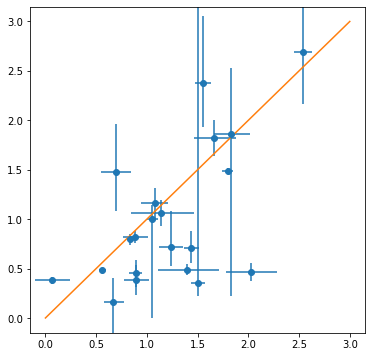

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
plt.errorbar(xray['GamPL'],xray['Gam1'], xerr=[xray['GamPL']-xray['b_GamPL'],xray['B_GamPL']-xray['GamPL']], yerr=[abs(xray['e_Gam1']),abs(xray['E_Gam1'])],fmt='o')
#print(xray.loc[(xray['GamPL']>0.5) & (xray['GamPL']<0.6), ['GamPL','B_GamPL','b_GamPL','Gam1','E_Gam1','e_Gam1']])
plt.plot([0,3], [0,3])
plt.show()

0.0 (+1.0, -0.0)
0.0 (+nan, -nan)
2.0 (+0.1, -0.3)
2.0 (+1.004987562112089, -0.3)
C 0.0 (+nan, -nan) 1.2994443995457372 0.0 (+nan, -nan)


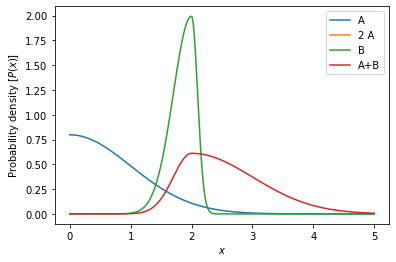

1.0 (+0.0, -inf)
3.0 ± 5.0
4.0 (+5.0, -inf)
0.21 ± 35.0


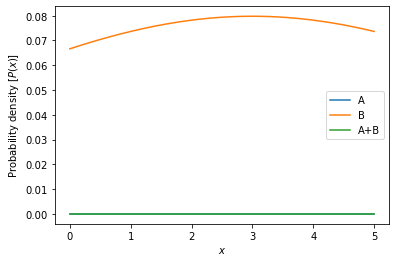

In [19]:
A = AsymmetricUncertainty(0,1,0)
#A = AsymmetricUncertainty(1,0,1)
print(A)
print(AsymmetricUncertainty(2,0,0)*A)
B = AsymmetricUncertainty(2,0.1,0.3)
print(B)
print(A+B)
x = np.linspace(0,5,250)

C_1 = bandshift(A,(0.5,1),(0.5,1.2),1.7)
C_2 = bandshift(1,(0.5,1),(0.5,1.2),1.7)
print('C',C_1,C_2,A*2)

plt.plot(x,A.pdf(x),label="A")
plt.plot(x,(2*A).pdf(x),label="2 A")
plt.plot(x,B.pdf(x),label="B")
plt.plot(x, (A+B).pdf(x),label="A+B")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Probability density [$P(x)$]")
plt.show()

A = AsymmetricUncertainty(1,0,np.inf)
print(A)
B = AsymmetricUncertainty(3,5,5)
print(B)
print(A+B)
x = np.linspace(0,5,250)
print(AsymmetricUncertainty(0.3,50,50)*0.7)

plt.plot(x,A.pdf(x),label="A")

plt.plot(x,B.pdf(x),label="B")
plt.plot(x, (A+B).pdf(x),label="A+B")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Probability density [$P(x)$]")
plt.show()

## Converting X-ray fluxes

In [20]:
# Determining X-ray fluxes at CXO s,m,h bands in priority of CSC -> XMM -> XRT
# X_pos and X_flux are not necessarily coming from the same X-ray catalog since some X-ray catalog has the valid coordinate but the fluxes might be Null

for i in xray[xray["_2CXO"].notna() | xray["_4XMM"].notna() | xray["_2SXPS"].notna()].index:
    
    cxoflux, xmmflux, xrtflux = xray.loc[i,CSC_fluxs].values, xray.loc[i,XMM_fluxs].values, xray.loc[i,XRT_fluxs].values
    exists = False
    
    if pd.notna(xray.loc[i,"GamPL"]): # spectral index from Chandra
        GamPL = float(xray.loc[i,"GamPL"])
        Gamma = AsymmetricUncertainty(GamPL,abs(xray.loc[i,"B_GamPL"]-GamPL),abs(GamPL-xray.loc[i,"b_GamPL"]))
        exists = True
    elif pd.notna(xray.loc[i,"Gam1"]): # spectral index from Swift
        Gam1 = float(xray.loc[i,"Gam1"])
        Gamma = AsymmetricUncertainty(Gam1,abs(xray.loc[i,"E_Gam1"]),abs(xray.loc[i,"e_Gam1"]))
        exists = True
    else: # assumption for general case
        Gamma = 1.7
    
    if all(pd.notna(cxoflux)) and ~((cxoflux[0]==1e-20) and (cxoflux[1]==1e-20) and (cxoflux[1]==1e-20)): # good Chandra observations present
        
        #print(cxoflux)
        pos_err = xray.loc[i,["B_Fluxs","B_Fluxm","B_Fluxh"]] - cxoflux
        neg_err = cxoflux - xray.loc[i,["b_Fluxs","b_Fluxm","b_Fluxh"]]
        converted = []
        for j in range(3):
            converted.append(AsymmetricUncertainty(cxoflux[j],pos_err[j],neg_err[j]))
        source = "CXO"
        
    elif all(pd.notna(xmmflux)) and ~((xmmflux[0]==1e-20) and (xmmflux[1]==1e-20) and (xmmflux[2]==1e-20) and (xmmflux[3]==1e-20)): # no Chandra, but good XMM
        #print(xmmflux)
        xmmerr = xray.loc[i,["e_"+band for band in XMM_fluxs]]
        mergedxmm = np.array([AsymmetricUncertainty(xmmflux[0],xmmerr[0],xmmerr[0]),
                              AsymmetricUncertainty(xmmflux[1],xmmerr[1],xmmerr[1]),
                              AsymmetricUncertainty(xmmflux[2],xmmerr[2],xmmerr[2])+AsymmetricUncertainty(xmmflux[3],xmmerr[3],xmmerr[3])])
        origbands = [(0.5,1),(1,2),(2,12)]
        converted = [bandshift(flux,xmmband,cxoband,Gamma) for flux,xmmband,cxoband in
                     zip(mergedxmm,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XMM"
        
    elif all(pd.notna(xrtflux)) and (xrtflux[0]>1e-20): # neither Chandra nor XMM, but good Swift-XRT
        #print(xrtflux[0])
        pos_err = xray.loc[i,"E_FPO0"]
        neg_err = xray.loc[i,"e_FPO0"]
        origbands = [(0.3,10),(0.3,10),(0.3,10)]
        converted = [bandshift(flux,xrtband,cxoband,Gamma) for flux,xrtband,cxoband in
                     zip([AsymmetricUncertainty(xrtflux,abs(pos_err),abs(neg_err))]*3,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XRT"
        
    else:
        converted = np.nan
        source = np.nan
        continue
    
    
    for j,b in enumerate("smh"):
        xray.loc[i,f"Flux_{b}"]   = converted[j].value
        xray.loc[i,f"E_Flux_{b}"] = converted[j].plus
        xray.loc[i,f"e_Flux_{b}"] = converted[j].minus
    
    xray.loc[i,"X_flux"] = source
    if exists:
        xray.loc[i,"Gamma"] = Gamma.value
        xray.loc[i,"E_Gamma"] = Gamma.plus
        xray.loc[i,"e_Gamma"] = Gamma.minus
        

In [21]:
for j, band in enumerate("smh"):
    xray.loc[xray[f"Flux_{band}"]<1e-19, f"Flux_{band}"] = 1e-20 
    xray.loc[xray[f"e_Flux_{band}"]<1e-19, f"e_Flux_{band}"] = 1e-20 

In [22]:
print('dropping those with invalid X-ray fluxes')
print(xray.loc[xray["X_flux"].isna(), ['_q', '_2CXO',  'Flag', '_RAJ2000_X', '_DEJ2000_X']+CSC_fluxs+XMM_fluxs+XRT_fluxs+\
                                 ['Flux_s', 'Flux_m', 'Flux_h', 'X_flux', 'Gamma']])
xray = xray.dropna(subset=['X_flux']).reset_index(drop=True)
print(len(xray))

dropping those with invalid X-ray fluxes
         _q             _2CXO Flag  _RAJ2000_X  _DEJ2000_X         Fluxs  \
24    514.0  J021856.8+570742  CXO   34.736726   57.128502           NaN   
52   1608.0  J135217.3-662415  CXO  208.072096  -66.404350  5.611409e-16   
54   1703.0  J155355.8-235841  CXO  238.482763  -23.978212  9.810809e-14   
55   1758.0  J163709.5-103401  CXO  249.289841  -10.567142  1.486114e-12   
157     121               NaN  XRT   13.726900  -72.454910           NaN   
159     227               NaN  XRT   14.288530  -72.447910           NaN   
171    1332               NaN  XRT  156.503590  -57.825920           NaN   
179    1927               NaN  XRT  274.637350  -13.752170           NaN   

            Fluxm         Fluxh  Flux2  Flux3  Flux4  Flux5          FPO0  \
24            NaN  1.000000e-20    NaN    NaN    NaN    NaN           NaN   
52   3.745817e-16           NaN    NaN    NaN    NaN    NaN           NaN   
54   8.055015e-14           NaN    NaN    N

In [23]:
print(xray[['X_flux']].value_counts())
print(xray.groupby(['X_flux','Flag']).size())
print(xray.loc[(xray.X_flux=='XMM') & (xray.Flag.str.contains('CXO')), ['Fluxs','Fluxm','Fluxh']])

X_flux
XMM       83
CXO       68
XRT       26
dtype: int64
X_flux  Flag       
CXO     CXO            18
        CXO+XMM        15
        CXO+XMM+XRT    27
        CXO+XRT         8
XMM     CXO+XMM         1
        CXO+XMM+XRT     6
        XMM            55
        XMM+XRT        21
XRT     CXO+XRT         1
        XRT            25
dtype: int64
           Fluxs         Fluxm         Fluxh
0   1.000000e-20  1.000000e-20  1.000000e-20
13  1.000000e-20  1.000000e-20  1.000000e-20
17           NaN           NaN           NaN
20  1.000000e-20  1.000000e-20  1.000000e-20
40           NaN           NaN           NaN
54           NaN           NaN           NaN
62  2.354773e-15  1.540291e-15           NaN


43


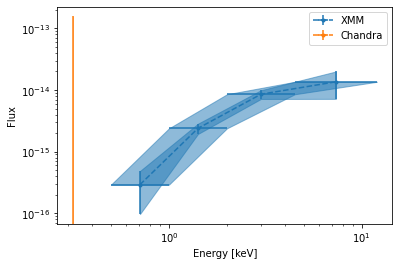

48


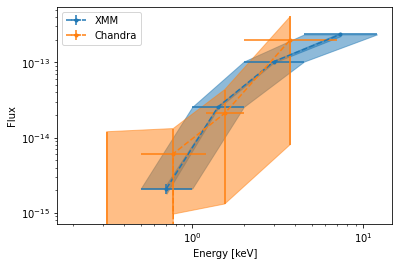

50


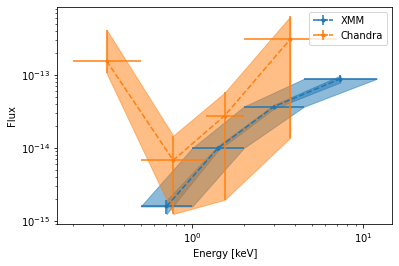

52


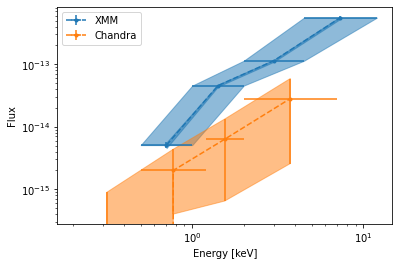

60


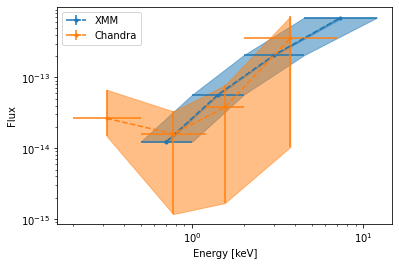

66


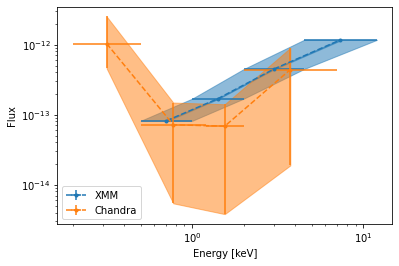

67


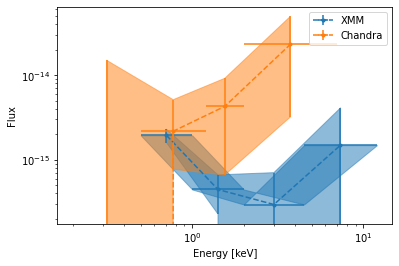

69


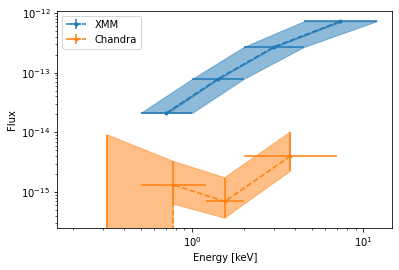

71


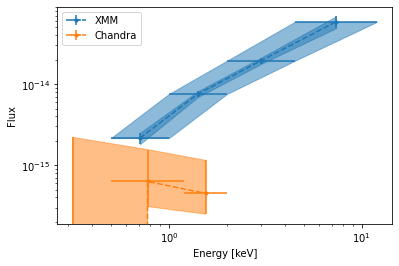

82


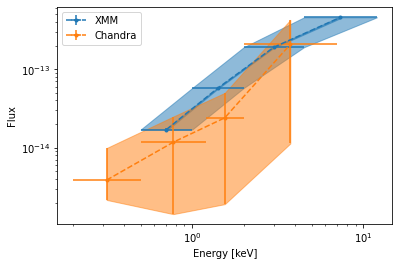

92


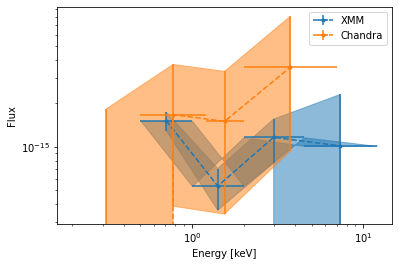

117


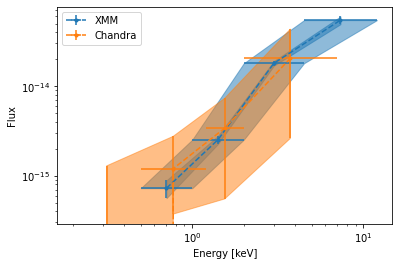

140


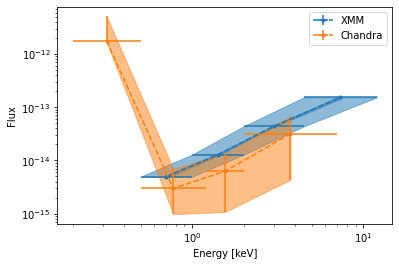

164


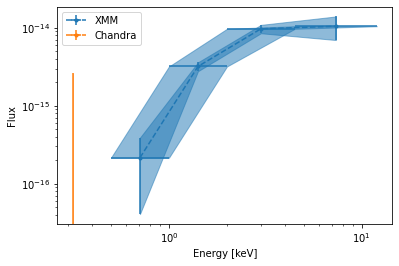

231


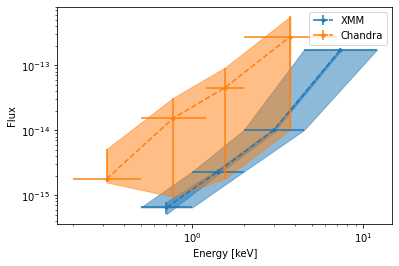

254


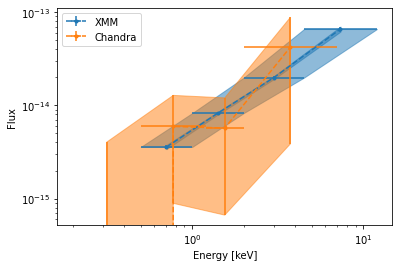

258


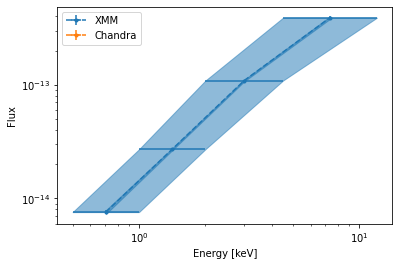

261


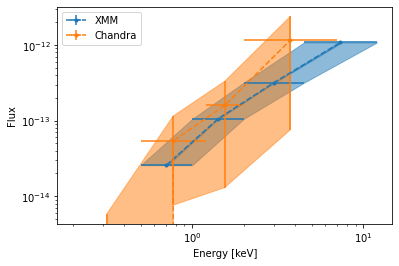

266


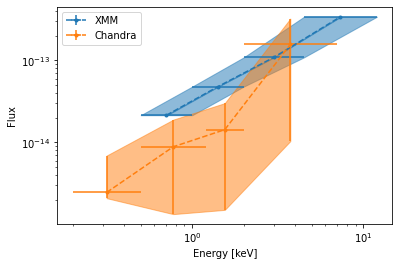

271


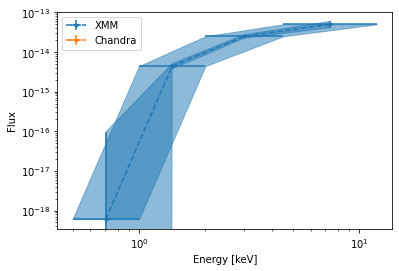

273


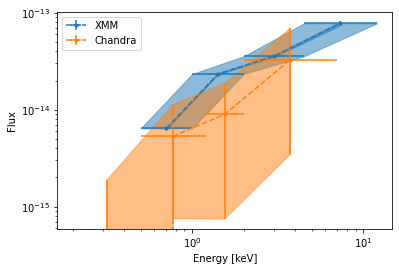

275


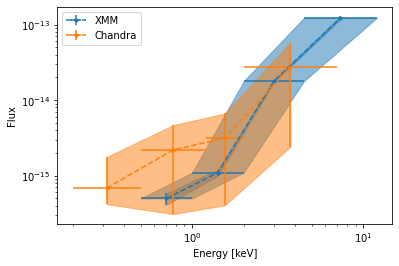

517


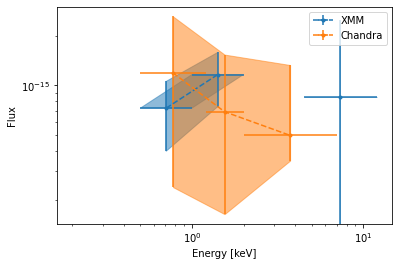

597


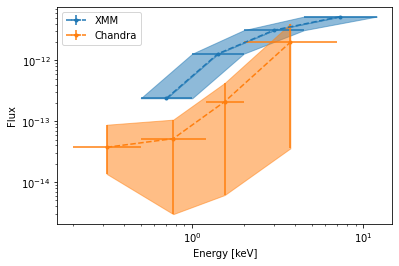

682


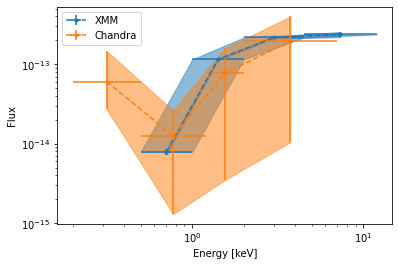

688


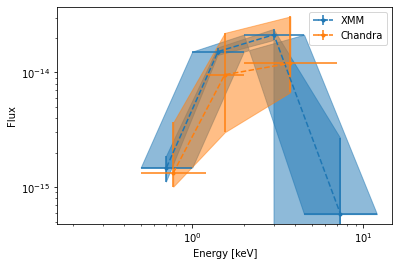

758


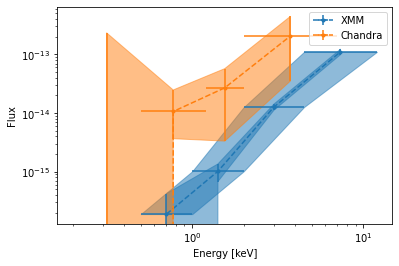

772


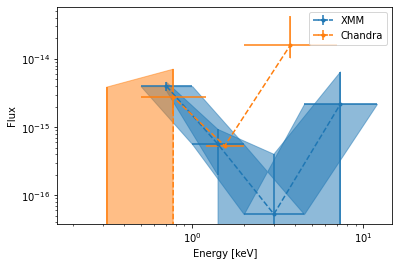

856


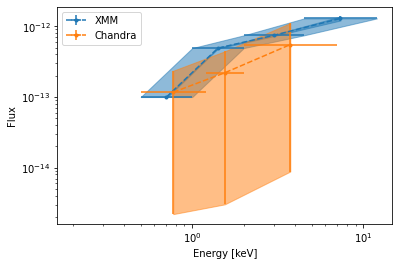

857


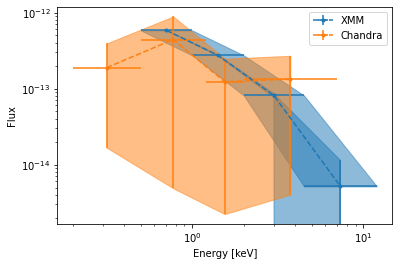

892


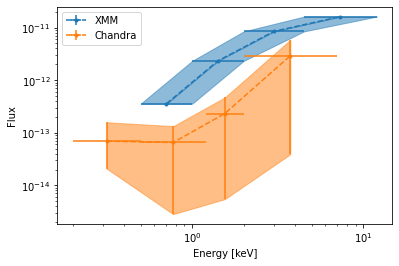

1001


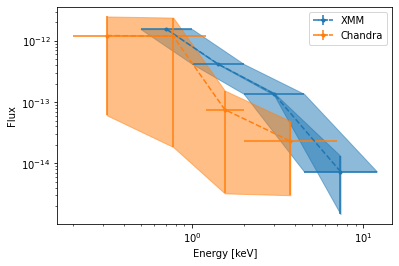

1168


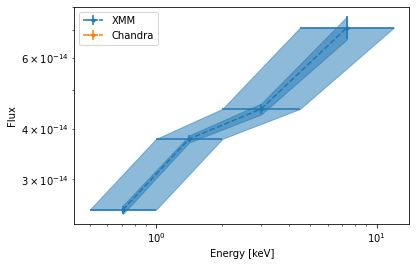

1563


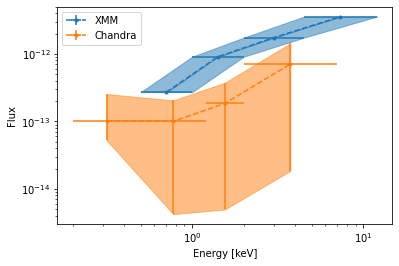

1601


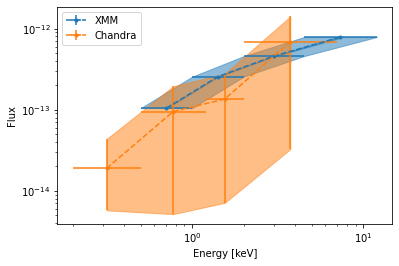

1851


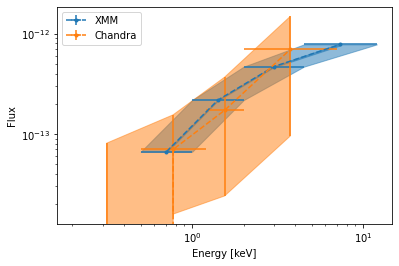

1858


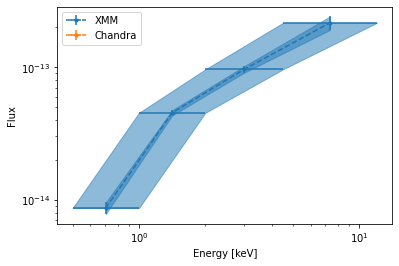

1868


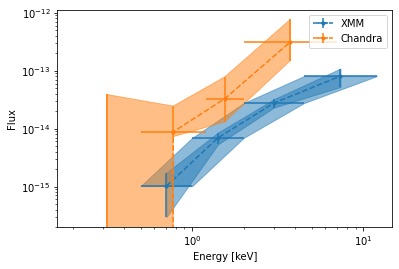

1875


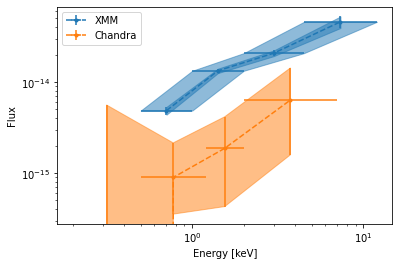

1887


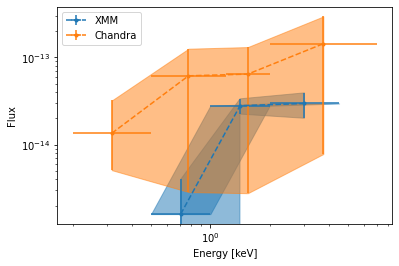

1891


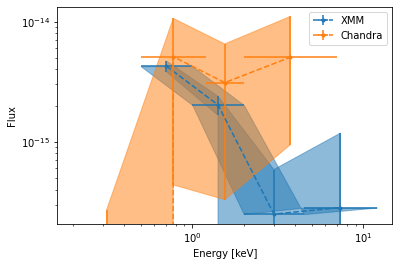

1893


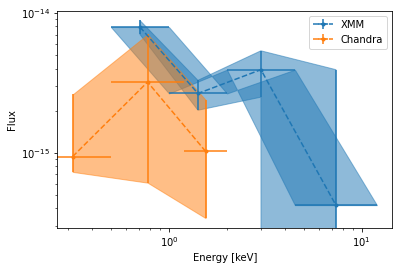

1895


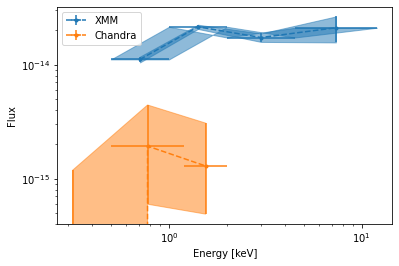

1896


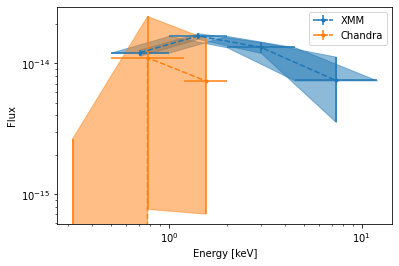

1900


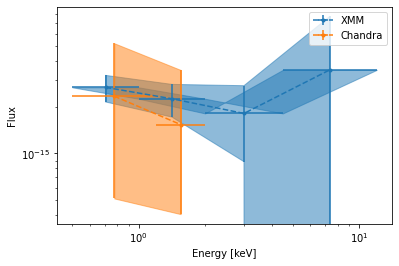

1903


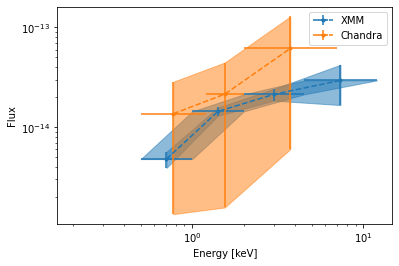

1930


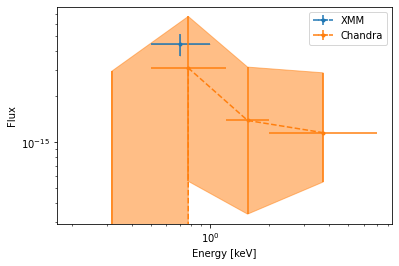

1931


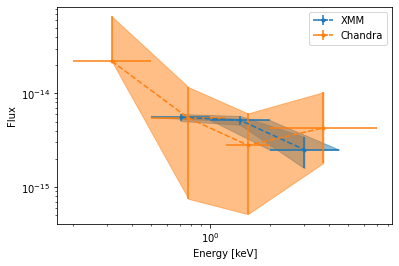

2123


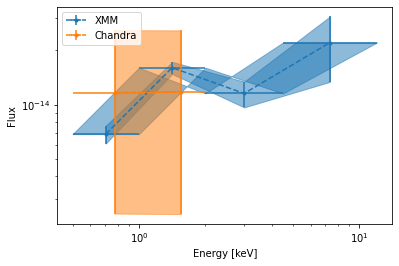

In [24]:
log_mean = lambda x1,x2 : 10**np.mean((np.log10(x1),np.log10(x2)))
xmm_E = np.array([log_mean(0.5,1),log_mean(1,2),log_mean(2,4.5),log_mean(4.5,12)])
cxo_E = np.array([log_mean(0.2,0.5),log_mean(0.5,1.2),log_mean(1.2,2),log_mean(2,7)])
for idx,obj in xray[xray["_2CXO"].notna() & xray["_4XMM"].notna()].iterrows():
    obj = obj.replace(1.0e-20,np.nan)
#     obj = obj.replace(0,np.nan)
    print(int(obj["_q"]))
    plt.errorbar(xmm_E,obj[["Flux2","Flux3","Flux4","Flux5"]],
                 xerr=[xmm_E-np.array([0.5,1,2,4.5]), np.array([1,2,4.5,12])-xmm_E],
                 yerr=obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]],
                 linestyle="--",marker=".",label="XMM")
    lower = obj[["Flux2","Flux3","Flux4","Flux5"]].values - obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]].values
    upper = obj[["Flux2","Flux3","Flux4","Flux5"]].values + obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]].values
    plt.fill_between(xmm_E,np.array(lower,dtype=float),np.array(upper,dtype=float),color="C0",alpha=0.5)
    plt.fill_betweenx(np.array(obj[["Flux2","Flux3","Flux4","Flux5"]].values,dtype=float),[0.5,1,2,4.5],[1,2,4.5,12],
                      color="C0",alpha=0.5)
    plt.errorbar(cxo_E,obj[["Fluxu","Fluxs","Fluxm","Fluxh"]],
                 xerr=[cxo_E-np.array([0.2,0.5,1.2,2]), np.array([0.5,1.2,2,7])-cxo_E],
                 yerr=[obj[["b_Fluxu","b_Fluxs","b_Fluxm","b_Fluxh"]],
                       obj[["B_Fluxu","B_Fluxs","B_Fluxm","B_Fluxh"]]],
                 linestyle="--",marker=".",label="Chandra")
    lower = obj[["Fluxu","Fluxs","Fluxm","Fluxh"]].values - obj[["b_Fluxu","b_Fluxs","b_Fluxm","b_Fluxh"]].values
    upper = obj[["Fluxu","Fluxs","Fluxm","Fluxh"]].values + obj[["B_Fluxu","B_Fluxs","B_Fluxm","B_Fluxh"]].values
    plt.fill_between(cxo_E,np.array(lower,dtype=float),np.array(upper,dtype=float),color="C1",alpha=0.5)
    
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Energy [keV]")
    plt.ylabel("Flux")
    plt.show()

## Backward-matching X-ray sources to Gaia

In [25]:
v = Vizier(columns=['all', '_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

radec = [[xray.loc[j,'_RAJ2000_X'], xray.loc[j, '_DEJ2000_X']] for j in range(len(xray))]
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))

# matching to gaiadr3
X_ga = v.query_region(rd, catalog="I/355/gaiadr3", radius='9s')[0]
X_ga['Source'] = X_ga['Source'].astype(str)
X_ga = X_ga.to_pandas()
X_ga = find_nearest(X_ga, ind_col='Source', sep_col='_r', check=False, drop=False)
print(len(X_ga))

# matching to gaiadr3paramp
X_gapar = v.query_region(rd, catalog="I/355/paramp", radius="9s")[0]["_q","_r","Source","Pstar","SpType-ELS"]
X_gapar['Source'] = X_gapar['Source'].astype(str)
X_gapar = X_gapar.to_pandas()
X_gapar = find_nearest(X_gapar, ind_col='Source', sep_col='_r', check=False, drop=False)
X_gaia = pd.merge(X_ga, X_gapar, on='Source', how="outer")
print(len(X_gaia))

# matching to gaiaedr3dist
X_gaiadist = v.query_region(rd, catalog="I/352/gedr3dis", radius='9s')[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo","Flag"]
X_gaiadist['Source'] = X_gaiadist['Source'].astype(str)
X_gaiadist = X_gaiadist.to_pandas()
X_gaiadist = find_nearest(X_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)
X_gaia = pd.merge(X_gaia, X_gaiadist, on='Source', how="outer")
print(len(X_gaia))

#print(X_gaia.columns)
X_gaia = X_gaia.rename(columns={'_q':'_q_edr3dist','_r':'_r_edr3dist','_q_x':'_q','_r_x':'_r','_q_y':'_q_dr3par','_r_y':'_r_dr3par'})
#X_gaia['BP-RP'] = X_gaia['BPmag']-X_gaia['RPmag']
X_gaia['abs_BPmag'] = X_gaia['BPmag']-5*(np.log10(X_gaia['rgeo'])-1)


Before cleaning multiple matches: 1101 rows.
After cleaning multiple matches: 1097 rows.
1097
Before cleaning multiple matches: 775 rows.
After cleaning multiple matches: 771 rows.
1097
Before cleaning multiple matches: 838 rows.
After cleaning multiple matches: 834 rows.
1097


In [26]:
#print(len(xray))
print(xray['X_pos'].value_counts())
#xray['X_pos']
print(xray["Flag"].value_counts())
print(xray.groupby(['X_pos','Flag']).size())
#print(xray[xray.X_pos=='CXO'])

CXO    76
XMM    76
XRT    25
Name: X_pos, dtype: int64
XMM            55
CXO+XMM+XRT    33
XRT            25
XMM+XRT        21
CXO            18
CXO+XMM        16
CXO+XRT         9
Name: Flag, dtype: int64
X_pos  Flag       
CXO    CXO            18
       CXO+XMM        16
       CXO+XMM+XRT    33
       CXO+XRT         9
XMM    XMM            55
       XMM+XRT        21
XRT    XRT            25
dtype: int64


In [27]:
# cleaning matches outside corresponding X-ray error circles since I used 9" for all matches for convenience

print('Before cleaning matches outside X-ray error circles:',len(X_gaia))  

search_radii = {'CXO': 2, 'XMM':5, 'XRT':9}

for i in X_gaia['_q'].unique():
    
    drop_idx = X_gaia[(X_gaia['_q'] == i) & (X_gaia['_r'] > search_radii[xray.loc[i-1, 'X_pos']] ) ].index

    X_gaia.drop(drop_idx, inplace = True)


print('After cleaning matches outside X-ray error circles:',len(X_gaia))

Before cleaning matches outside X-ray error circles: 1097
After cleaning matches outside X-ray error circles: 443


In [28]:
df_BeSS

,#,Be star,Category,RA,DEC,V,Type,vsini,Nb of spectra in BeSS,_RAJ2000,_DEJ2000,conf_flag
0,1,BD+62 2346,Classical,00 01 24.70,63 30 15.73,9.730,B0Ve,<NA>,3,0.352917,63.504369,0
1,2,HD 224905,Classical,00 01 38.63,60 26 59.72,8.470,B1Vne,<NA>,85,0.410958,60.449922,0
2,3,HD 225095,Classical,00 03 27.15,55 33 03.23,7.950,B2IVne,<NA>,234,0.863125,55.550897,0
3,4,2 Cet,Classical,00 03 44.39,-17 20 09.57,4.543,B9IVne,<NA>,95,0.934958,-17.335992,0
4,5,10 Cas,Classical,00 06 26.54,64 11 46.21,5.567,B9IIIe,125,292,1.610583,64.196169,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2259,2260,BD+65 1970,Classical,23 57 34.10,66 25 53.84,10.170,B5e,<NA>,1,359.392083,66.431622,0
2260,2261,LQ And,Classical,23 58 46.44,46 24 47.44,6.542,B4Vne,300,507,359.693500,46.413178,0
2261,2262,HD 224544,Classical,23 58 49.24,32 22 54.14,6.524,B6IVe,260,402,359.705167,32.381706,0
2262,2263,HD 224599,Classical,23 59 14.97,60 01 20.93,9.700,B0.5Vnnpe,<NA>,2,359.812375,60.022481,0


    _RAJ2000_X  _DEJ2000_X X_pos
77   13.955317  -72.452594   XMM
       #           Be star   _RAJ2000   _DEJ2000
150  151  Cl* NGC 330 G 68  13.953201 -72.453576
    _RAJ2000_X  _DEJ2000_X X_pos
78   14.158752  -72.302808   XMM
       #                 Be star   _RAJ2000   _DEJ2000
215  216  Cl* NGC 330 ELS 004509  14.161507 -72.303667
     _RAJ2000_X  _DEJ2000_X X_pos
112  165.625379   -60.81516   XMM
         #    Be star    _RAJ2000   _DEJ2000
1410  1411  HD 305891  165.624895 -60.815517
     _RAJ2000_X  _DEJ2000_X X_pos
113  174.582971  -63.342137   XMM
         #   Be star    _RAJ2000   _DEJ2000
1475  1476  V870 Cen  174.583015 -63.343478
     _RAJ2000_X  _DEJ2000_X X_pos
114  174.743643   -63.47744   XMM
         #    Be star    _RAJ2000   _DEJ2000
1478  1479  HD 308829  174.741459 -63.477494
     _RAJ2000_X  _DEJ2000_X X_pos
140  303.730911   36.853153   XMM
         #    Be star    _RAJ2000   _DEJ2000
2074  2075  HD 228535  303.730529  36.853539
     _RAJ2000_X  _DEJ2000_X X_

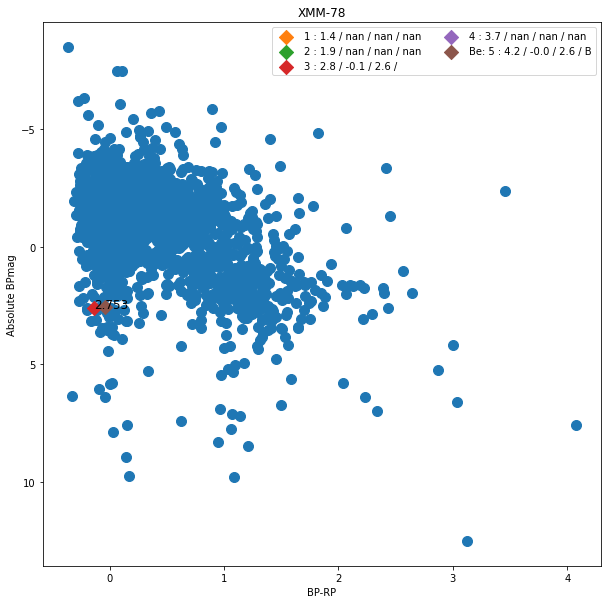

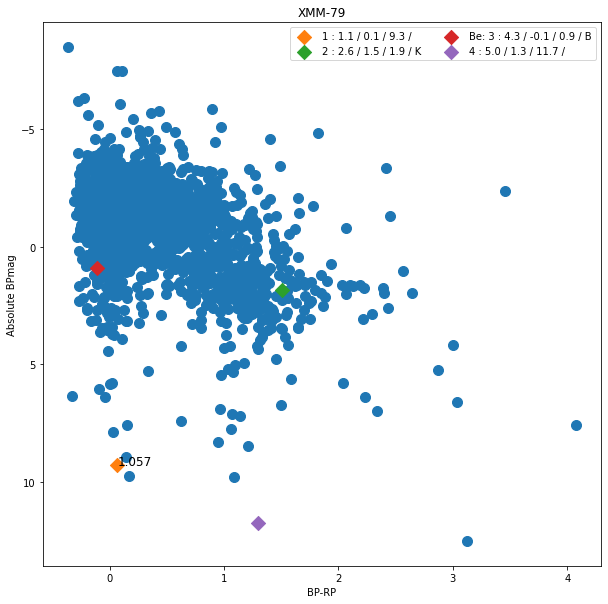

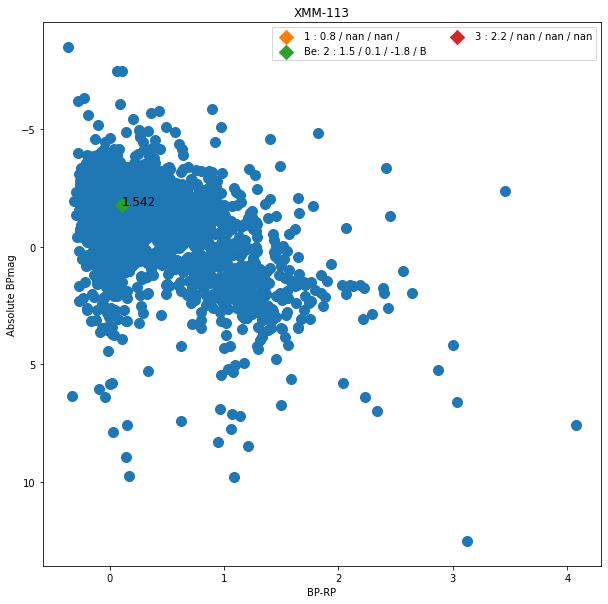

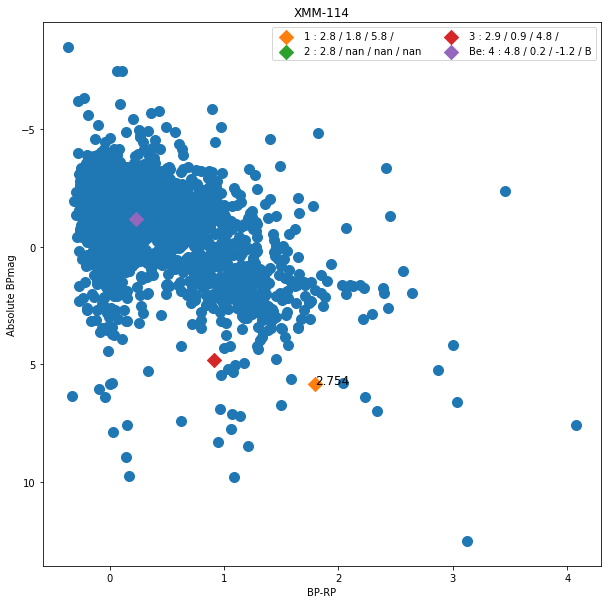

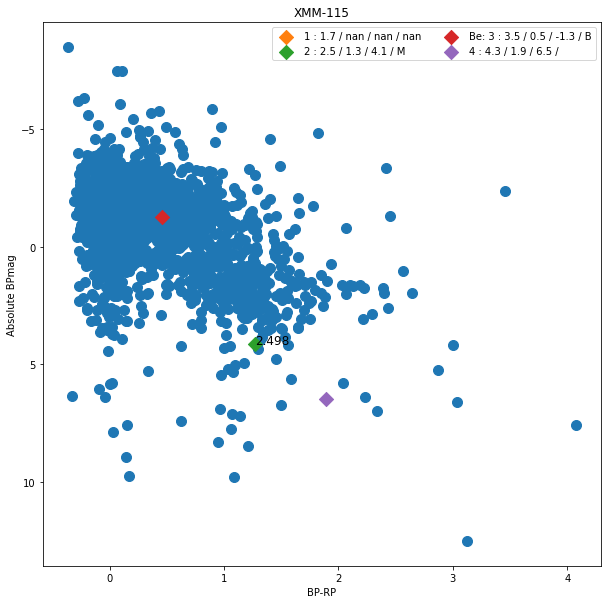

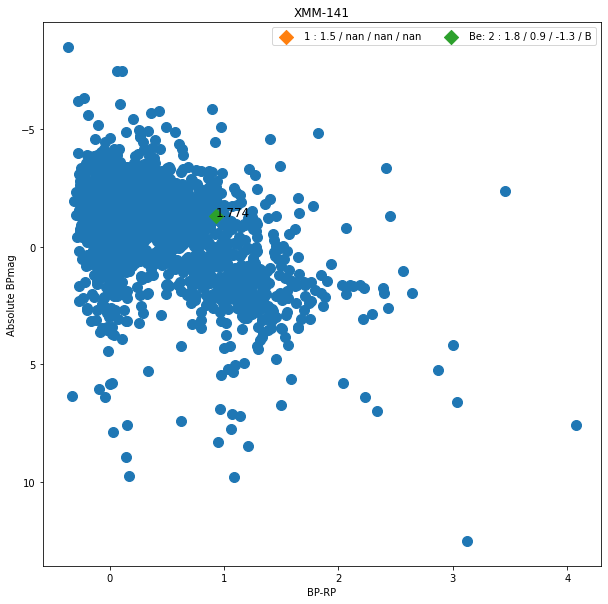

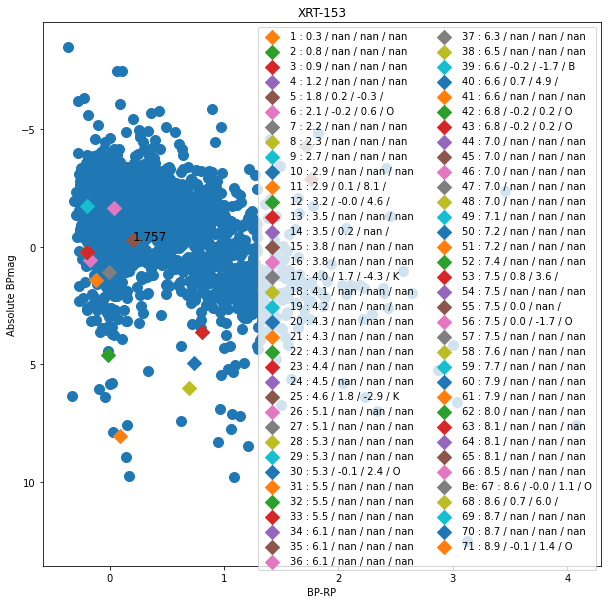

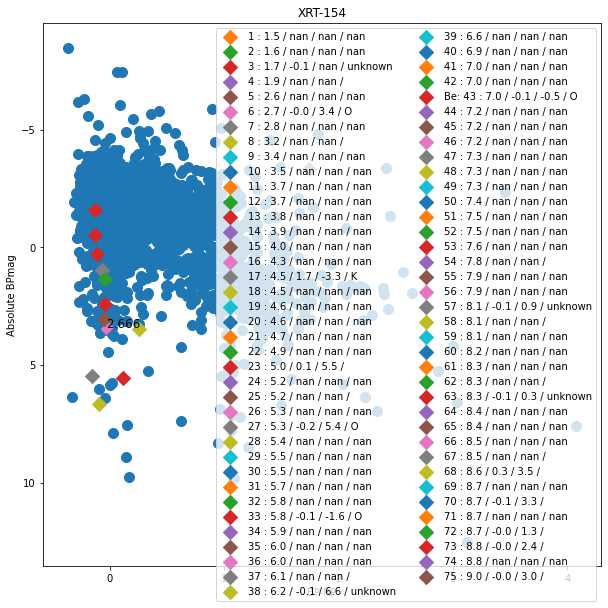

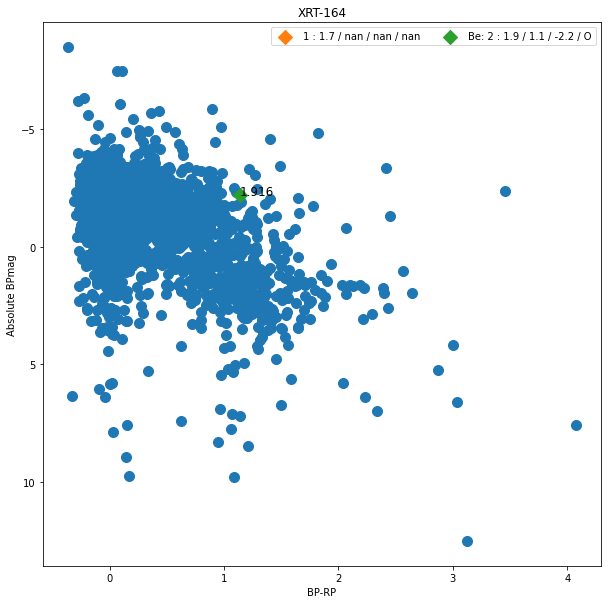

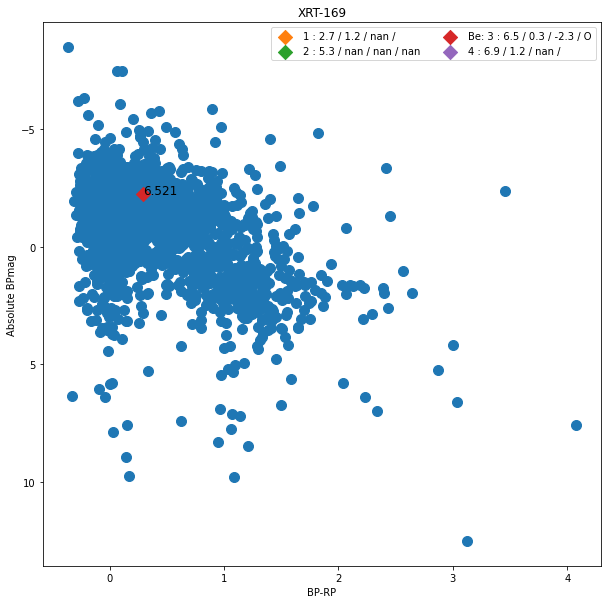

In [29]:
# marking questionable gaia counterparts of X-ray sources with multiple matches using conf_flag_X2O column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots
# selecting the nearest gaia matches with valid color and distance measurements (plotted along with their separation in ")

X_gaia_select = pd.DataFrame()

for i in X_gaia['_q'].unique():

    df_sub = X_gaia.loc[X_gaia['_q']==i].sort_values(by=['_r'])
    instances = len(df_sub)
    if instances == 1:
        df_sub['conf_flag_X2O'] = 0
        X_gaia_select = X_gaia_select.append(df_sub, ignore_index=True)
    else:
        df_src = df_sub.loc[df_sub['_r'] ==min(df_sub['_r'])]
        if len(df_src)>1:
            df_nearest = df_src.head(1)
        else:
            df_nearest = df_src
            
        if df_nearest['Source'].values in df_gaia['Source'].values:
            df_nearest['conf_flag_X2O'] = 1
            X_gaia_select = X_gaia_select.append(df_nearest, ignore_index=True)
        
        if df_nearest['Source'].values not in df_gaia['Source'].values:
            print(xray.loc[xray.index==i-1, ['_RAJ2000_X','_DEJ2000_X','X_pos']])
            
            fig, ax = plt.subplots(figsize=(10,10))

            ax.scatter(df_gaia['BP-RP'], df_gaia['abs_BPmag'], s=100)

            j=1
            for s in df_sub.index:
                
                if df_sub.loc[s, 'Source'] in df_gaia['Source'].values:
                    print(df_comb.loc[df_comb.Source== df_sub.loc[s, 'Source'],['#','Be star','_RAJ2000', '_DEJ2000']])
                    
                    ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="Be: %1d : %.1f / %.1f / %.1f / %s" % (j, df_sub.loc[s,'_r'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], df_sub.loc[s,'SpType-ELS']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                else:
                
                    ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="%1d : %.1f / %.1f / %.1f / %s" % (j, df_sub.loc[s,'_r'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], df_sub.loc[s,'SpType-ELS']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                j+=1
            
            df_sub_select = df_sub[(~df_sub['BP-RP'].isnull()) & (~df_sub['abs_BPmag'].isnull())].iloc[0]
            df_sub_select['conf_flag_X2O'] = 2
            X_gaia_select = X_gaia_select.append(df_sub_select, ignore_index=True)
            # #print(df_sub_select)
            ax.text(df_sub_select['BP-RP'], df_sub_select['abs_BPmag'], str(df_sub_select['_r']), fontsize=12)
                
                
            plt.legend(ncol=2,fontsize=10)
            plt.gca().invert_yaxis()
            plt.xlabel('BP-RP')
            plt.ylabel('Absolute BPmag')
            plt.title(xray.loc[i-1, 'X_pos']+'-'+str(int(i)))

        
#print(cat,'\n')       

In [30]:
X_gaia_select.head()

,Source,_q,_RAJ2000,_DEJ2000,_r,DR3Name,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,...,_r_edr3dist,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag,abs_BPmag,conf_flag_X2O
0,4685949198438263040,1.0,12.142170,-73.042030,0.577,Gaia DR3 4685949198438263040,12.142182,0.0290,-73.042036,0.0249,...,0.577,19029.16990,14444.24220,24856.03520,16394.40620,11669.77730,22842.53520,10022.0,-1.613278,1
1,4685944907831053184,2.0,12.306773,-73.193853,0.235,Gaia DR3 4685944907831053184,12.306781,0.0358,-73.193858,0.0332,...,0.235,11068.45800,8620.13672,15595.54200,9067.24121,8236.38379,9871.73828,10022.0,1.272432,0
2,4685944942190772224,3.0,12.374189,-73.182917,0.289,Gaia DR3 4685944942190772224,12.374212,0.1095,-73.182921,0.1040,...,0.289,5506.32373,4095.96826,9682.07422,3487.76782,2732.50659,3959.38037,10022.0,2.517645,0
3,4685927315640017792,4.0,12.425033,-73.387410,0.038,Gaia DR3 4685927315640017792,12.425041,0.0178,-73.387415,0.0194,...,0.038,22524.32230,17164.30860,28180.70510,27205.68950,18131.46880,34078.11720,10122.0,-1.922681,1
4,4685928999266932864,5.0,12.686283,-73.268175,0.185,Gaia DR3 4685928999266932864,12.686294,0.0229,-73.268181,0.0228,...,0.185,23639.76560,15648.85740,39283.18750,10989.64550,9595.06348,14631.56540,10122.0,-1.521895,0


In [31]:
#print(Counter(X_gaia_select['conf_flag_X2O']))
print(xray.columns)

Index(['_q', '_r_CSC', '_RAJ2000_CSC', '_DEJ2000_CSC', 'r0', '_2CXO', 'S_N',
       'HRhm', 'HRhs', 'HRms', 'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm',
       'B_Fluxm', 'b_Fluxm', 'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu',
       'b_Fluxu', 'GamPL', 'B_GamPL', 'b_GamPL', 'NHPL', '_r_XMM',
       '_RAJ2000_XMM', '_DEJ2000_XMM', 'ePos', '_4XMM', 'srcML', 'Flux1',
       'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4',
       'Flux5', 'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1',
       'e_HR1', 'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_r_XRT',
       '_RAJ2000_XRT', '_DEJ2000_XRT', 'Err90', '_2SXPS', 'Det', 'CR0',
       'E_CR0', 'e_CR0', 'HR1_XRT', 'HR2_XRT', 'CR1', 'e_CR1', 'CR2', 'E_CR2',
       'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0', 'FPO0', 'E_FPO0', 'e_FPO0',
       'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1', 'Flag', 'X_pos', '_RAJ2000_X',
       '_DEJ2000_X', 'Flux_s', 'E_Flux_s', 'e_Flux_s', 'Flux_m', 'E_Flux_m',
       'e_Flux_m', 'Flux

In [32]:
df_BeSS_Gaia = pd.read_csv("./catalogs/BeSS2Gaia.csv")

xray = xray.drop(columns=['_RAJ2000_CSC', '_DEJ2000_CSC','_RAJ2000_XMM', '_DEJ2000_XMM','_RAJ2000_XRT', '_DEJ2000_XRT'])#.rename(columns={'_RAJ2000':'_RAJ2000_X', '_DEJ2000':'_DEJ2000_X'})
xray['index_X'] = xray.index+1

print('merging all three (gaia, xray and BeSS) tables')
#print(len(xray))
#print(len(xray['_q'].unique()))
#print(xray.loc[~(xray['_q'].isin(df_BeSS_Gaia['_q'])) ,['_q']])
master = pd.merge(df_BeSS_Gaia, xray, left_on='#',right_on='_q', how='inner')
#print(master.columns)
master = pd.merge(master, X_gaia_select[['_q','conf_flag_X2O']], left_on = 'index_X', right_on='_q', how='outer')
print(len(master))
#print(Counter(master['conf_flag_X2O']))

master.to_csv('./catalogs/master_BeSS_Xray_Gaia.csv', index=False) 

merging all three (gaia, xray and BeSS) tables
177


In [33]:
master = pd.read_csv('./catalogs/master_BeSS_Xray_Gaia.csv') 


## matching with other multiwavelength catalogs (2mass, catwise, unwise, allwise) using 1" to optical coordinates

In [34]:
master['_q_MW'] = master.index+1

cats = {
    'gaia':     'I/355/gaiadr3',
    'gaiadist': 'I/352/gedr3dis',
    '2mass':    'II/246/out',
    'catwise':  'II/365/catwise',
    'unwise':   'II/363/unwise',
    'allwise':  'II/328/allwise',
    'vphas':    'II/341'
    }

ras = master['RA'].values
decs = master['DEC'].values

radec = [[ras[i], decs[i]] for i in range(len(ras))]
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))
        
for cat in ['2mass','catwise','unwise','allwise']:
    print(cat)
    
    viz = Vizier(row_limit=-1,  timeout=5000, columns=["**", "+_r"], catalog=cats[cat])
    
    query_res = viz.query_region(rd, radius=1.*u.arcsec)[0]
    df_MW = query_res.to_pandas()
    
    df_MW = find_nearest(df_MW, ind_col='_q', sep_col='_r').reset_index(drop=True)
    
    df_MW = df_MW.add_suffix('_'+cat)
    
    master = pd.merge(master, df_MW, left_on='_q_MW', right_on='_q_'+cat, how='outer')#, on=['_q_MW', '_q'])

2mass
Before cleaning multiple matches: 170 rows.
After cleaning multiple matches: 170 rows.
catwise
Before cleaning multiple matches: 122 rows.
After cleaning multiple matches: 121 rows.
unwise
Before cleaning multiple matches: 155 rows.
After cleaning multiple matches: 142 rows.
allwise
Before cleaning multiple matches: 139 rows.
After cleaning multiple matches: 139 rows.


In [35]:
print(master.columns[260:300])

master['PU_CU_unwise'] = master.apply(lambda row: max(row.e_XposW1_unwise,row.e_XposW2_unwise,row.e_YposW1_unwise,row.e_YposW2_unwise)*2.75*2., axis=1)
        
print(master['PU_CU_unwise'].max())

#master.to_csv('test.csv')

Index(['dELAT_catwise', 'e_dELAT_catwise', 'snrdELON_catwise',
       'snrdELAT_catwise', 'chi2pmRA_catwise', 'chi2pmDE_catwise',
       'ka_catwise', 'k1_catwise', 'k2_catwise', 'km_catwise', 'plx1_catwise',
       'e_plx1_catwise', 'plx2_catwise', 'e_plx2_catwise', 'Sep_catwise',
       'ccf_catwise', 'abf_catwise', 'WISEA_catwise', '_q_unwise', '_r_unwise',
       'objID_unwise', 'RAJ2000_unwise', 'DEJ2000_unwise', 'XposW1_unwise',
       'XposW2_unwise', 'YposW1_unwise', 'YposW2_unwise', 'FW1_unwise',
       'FW2_unwise', 'e_XposW1_unwise', 'e_XposW2_unwise', 'e_YposW1_unwise',
       'e_YposW2_unwise', 'e_FW1_unwise', 'e_FW2_unwise', 'q_W1_unwise',
       'q_W2_unwise', 'rchi2W1_unwise', 'rchi2W2_unwise', 'fFW1_unwise'],
      dtype='object')
5.5000001102248254e+20


In [36]:
# merging catwise and unwise catalogs for W1 and W2 bands

master.loc[:, 'W1mag_unwise'], master.loc[:, 'W2mag_unwise'] = np.nan, np.nan
master.loc[master['FW1_unwise']>0,'W1mag_unwise'] = 22.5-2.5*np.log10(master.loc[master['FW1_unwise']>0,'FW1_unwise']) - 0.004
master.loc[master['FW2_unwise']>0,'W2mag_unwise'] = 22.5-2.5*np.log10(master.loc[master['FW2_unwise']>0,'FW2_unwise']) - 0.032
master.loc[:, 'e_W1mag_unwise'], master.loc[:, 'e_W2mag_unwise'] = np.nan, np.nan
master.loc[master['FW1_unwise']>0,'e_W1mag_unwise'] = -2.5*np.log10(math.e)*master.loc[master['FW1_unwise']>0,'e_FW1_unwise']/master.loc[master['FW1_unwise']>0,'FW1_unwise']
master.loc[master['FW2_unwise']>0,'e_W2mag_unwise'] = -2.5*np.log10(math.e)*master.loc[master['FW2_unwise']>0,'e_FW2_unwise']/master.loc[master['FW2_unwise']>0,'FW2_unwise']

master = master.rename(columns={'W1mproPM_catwise':'W1mag_catwise','e_W1mproPM_catwise':'e_W1mag_catwise','W2mproPM_catwise':'W2mag_catwise','e_W2mproPM_catwise':'e_W2mag_catwise'})

for w in ['W1', 'W2']:
    master[w+'mag_wise12'] = master[w+'mag_allwise']
    master['e_'+w+'mag_wise12'] = master['e_'+w+'mag_allwise']
    
    s= np.where((master[w+'mag_wise12'].isnull()) & (~master[w+'mag_catwise'].isnull()))[0]
    print(len(s), 'use ',w,' from CatWISE2020 rather than AllWISE.')
    master.loc[s, w+'mag_wise12'] = master.loc[s, w+'mag_catwise']
    master.loc[s, 'e_'+w+'mag_wise12'] = master.loc[s, 'e_'+w+'mag_catwise']
    
    s= np.where((master[w+'mag_wise12'].isnull()) & (~master[w+'mag_unwise'].isnull()) & (master['PU_CU_unwise']<=2))[0]
    print(len(s), 'use ',w,' from UnWISE rather than AllWISE & CatWISE2020.')
    master.loc[s, w+'mag_wise12'] = master.loc[s, w+'mag_unwise']
    master.loc[s, 'e_'+w+'mag_wise12'] = master.loc[s, 'e_'+w+'mag_unwise']



11 use  W1  from CatWISE2020 rather than AllWISE.
8 use  W1  from UnWISE rather than AllWISE & CatWISE2020.
10 use  W2  from CatWISE2020 rather than AllWISE.
6 use  W2  from UnWISE rather than AllWISE & CatWISE2020.


In [37]:
# using rgeo for distance, correcting the distance for Gamma Cas

master['name_BeSS'] = master['Be star'] 
master['dist'] = master['rgeo']
master['E_dist'] = master['B_rgeo'] - master['rgeo']
master['e_dist'] = master['rgeo'] - master['b_rgeo'] 
master.loc[master['name_BeSS'] == 'gam Cas', 'dist'] = 168.4
master.loc[master['name_BeSS'] == 'gam Cas', 'E_dist'] = 3.5
master.loc[master['name_BeSS'] == 'gam Cas', 'e_dist'] = 3.3



In [38]:
master.columns[:60]

Index(['#', 'Be star', '_RAJ2000', '_DEJ2000', 'V', 'Type', 'vsini',
       'conf_flag', '_q_x', 'Source', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name',
       'Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE',
       'epsi', 'sepsi', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag',
       'e_RPmag', 'Teff', 'Pstar', 'SpType-ELS', 'rgeo', 'b_rgeo', 'B_rgeo',
       'rpgeo', 'b_rpgeo', 'B_rpgeo', 'BP-RP', 'abs_BPmag', 'gaia_conf', 'RA',
       'DEC', '_q_y', '_r_CSC', 'r0', '_2CXO', 'S_N', 'HRhm', 'HRhs', 'HRms',
       'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs'],
      dtype='object')

In [39]:
master

,#,Be star,_RAJ2000,_DEJ2000,V,Type,vsini,conf_flag,_q_x,Source,...,e_W1mag_unwise,e_W2mag_unwise,W1mag_wise12,e_W1mag_wise12,W2mag_wise12,e_W2mag_wise12,name_BeSS,dist,E_dist,e_dist
0,43,RX J0048.5-7302,12.142170,-73.042030,14.840,Be,NaN,0,43.0,4.685949e+18,...,-0.004713,-0.009477,14.116,0.030,13.827,0.032,RX J0048.5-7302,19029.169900,5826.865300,4584.927700
1,48,RX J0049.2-7311,12.306773,-73.193853,16.510,Be,NaN,0,48.0,4.685945e+18,...,-0.011981,-0.023802,15.186,0.014,15.162,0.023,RX J0049.2-7311,11068.458000,4527.084000,2448.321280
2,50,RX J0049.5-7310,12.374212,-73.182921,16.510,Be,NaN,0,50.0,4.685945e+18,...,-0.009268,-0.016264,14.529,0.015,14.390,0.015,RX J0049.5-7310,5506.323730,4175.750490,1410.355470
3,52,RX J0049.7-7323,12.424958,-73.387419,14.980,B2Ve,NaN,0,52.0,4.685927e+18,...,-0.003948,-0.008258,13.726,0.031,13.583,0.032,RX J0049.7-7323,22524.322300,5656.382800,5360.013700
4,60,DZ Tuc,12.686208,-73.268100,15.440,Be,NaN,0,60.0,4.685929e+18,...,-0.006338,-0.013667,14.592,0.030,14.367,0.040,DZ Tuc,23639.765600,15643.421900,7990.908200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,2215,HD 215227,340.738750,44.721736,8.810,B5ne,NaN,0,2215.0,1.982360e+18,...,-0.000542,-0.001167,7.386,0.028,7.026,0.019,HD 215227,1984.890140,80.632810,76.706670
173,2218,EM* MWC 659,341.939042,57.280772,10.150,B0IIIpe,NaN,0,2218.0,2.007135e+18,...,-0.000791,-0.001609,7.779,0.027,7.431,0.020,EM* MWC 659,3409.346680,170.262450,184.893310
174,2225,BD+61 2355,343.121625,62.686058,9.630,B7IVe,NaN,0,2225.0,2.207279e+18,...,-0.000277,-0.000569,8.557,0.022,8.545,0.017,BD+61 2355,590.133118,18.837707,22.363831
175,2233,V378 And,345.228125,38.707844,6.555,B3Vpe,370.0,0,2233.0,1.928350e+18,...,-0.000510,-0.000963,6.843,0.060,6.811,0.021,V378 And,369.219482,7.904725,6.692749


In [40]:
# matching to Simbad using 2" 

master_simbad = XMatch.query(cat1=Table.from_pandas(master),
                         cat2='vizier:SIMBAD',max_distance=2 * u.arcsec, colRA1='RA',colDec1='DEC')

master_simbad = find_nearest(master_simbad.to_pandas(), ind_col='#', sep_col='angDist')

master = pd.merge(master, master_simbad[['#','main_type','main_id','other_types']],on="#",  how="outer")
print(len(master))


Before cleaning multiple matches: 188 rows.
After cleaning multiple matches: 172 rows.
177


In [41]:
# adding catalog memberships that each source is matched to 

for i in master.index:
    flags = []
    
    for col, cat in zip(["_2CXO","_4XMM","_2SXPS","Source","_2MASS_2mass","objID_catwise","objID_unwise","AllWISE_allwise"], ["CSC","XMM","XRT","Gaia","2Mass","catwise","unwise","allwise"]):
        if pd.notna(master.loc[i,col]):
            flags.append(cat)
            
    master.loc[i,"Memberships"] = ",".join(flags)

In [42]:
master.to_csv('./catalogs/master_BeSS_Xray_Gaia_MW.csv', index=False)

In [43]:
# those sources have new CXO and XMM observations made 

#master.loc[master['name_BeSS']=='CD-29 5159', "Memberships"] = master.loc[master['name_BeSS']=='CD-29 5159', "Memberships"]+",CSC"
#master.loc[master['name_BeSS']=='EM* MWC 659', "Memberships"] = master.loc[master['name_BeSS']=='EM* MWC 659', "Memberships"]+",XMM"


In [44]:
master = pd.read_csv('./catalogs/master_BeSS_Xray_Gaia_MW.csv')
print(len(master))
master

177


,#,Be star,_RAJ2000,_DEJ2000,V,Type,vsini,conf_flag,_q_x,Source,...,W2mag_wise12,e_W2mag_wise12,name_BeSS,dist,E_dist,e_dist,main_type,main_id,other_types,Memberships
0,43,RX J0048.5-7302,12.142170,-73.042030,14.840,Be,NaN,0,43.0,4.685949e+18,...,13.827,0.032,RX J0048.5-7302,19029.169900,5826.865300,4584.927700,HMXB,LIN 110,*|Be?|Em*|HXB|IR|X,"CSC,XMM,XRT,Gaia,2Mass,catwise,unwise,allwise"
1,48,RX J0049.2-7311,12.306773,-73.193853,16.510,Be,NaN,0,48.0,4.685945e+18,...,15.162,0.023,RX J0049.2-7311,11068.458000,4527.084000,2448.321280,HMXB,RX J0049.2-7311,*|Be?|HXB|IR|Psr|X,"CSC,XMM,XRT,Gaia,2Mass,catwise,unwise"
2,50,RX J0049.5-7310,12.374212,-73.182921,16.510,Be,NaN,0,50.0,4.685945e+18,...,14.390,0.015,RX J0049.5-7310,5506.323730,4175.750490,1410.355470,HMXB,[MA93] 300,*|Em*|HXB|IR|X,"CSC,XMM,XRT,Gaia,2Mass,catwise,unwise"
3,52,RX J0049.7-7323,12.424958,-73.387419,14.980,B2Ve,NaN,0,52.0,4.685927e+18,...,13.583,0.032,RX J0049.7-7323,22524.322300,5656.382800,5360.013700,HMXB,LIN 139,*|Be?|Em*|HXB|IR|Psr|X,"CSC,XMM,XRT,Gaia,2Mass,catwise,unwise,allwise"
4,60,DZ Tuc,12.686208,-73.268100,15.440,Be,NaN,0,60.0,4.685929e+18,...,14.367,0.040,DZ Tuc,23639.765600,15643.421900,7990.908200,HMXB,V* DZ Tuc,*|El*|Em*|HXB|IR|Psr|V*|X,"CSC,XMM,XRT,Gaia,2Mass,catwise,unwise,allwise"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,2215,HD 215227,340.738750,44.721736,8.810,B5ne,NaN,0,2215.0,1.982360e+18,...,7.026,0.019,HD 215227,1984.890140,80.632810,76.706670,Be*,HD 215227,*|**|Be*|Em*|HX?|IR|UV|gam,"XMM,Gaia,2Mass,catwise,unwise,allwise"
173,2218,EM* MWC 659,341.939042,57.280772,10.150,B0IIIpe,NaN,0,2218.0,2.007135e+18,...,7.431,0.020,EM* MWC 659,3409.346680,170.262450,184.893310,Be*,EM* MWC 659,*|Be*|Em*|IR,"XMM,XRT,Gaia,2Mass,catwise,unwise,allwise"
174,2225,BD+61 2355,343.121625,62.686058,9.630,B7IVe,NaN,0,2225.0,2.207279e+18,...,8.545,0.017,BD+61 2355,590.133118,18.837707,22.363831,Be*,BD+61 2355,*|Be*|Em*|IR,"XMM,Gaia,2Mass,catwise,unwise,allwise"
175,2233,V378 And,345.228125,38.707844,6.555,B3Vpe,370.0,0,2233.0,1.928350e+18,...,6.811,0.021,V378 And,369.219482,7.904725,6.692749,Be*,HD 217543,*|Be*|Em*|IR|UV|V*,"XRT,Gaia,2Mass,catwise,unwise,allwise"


## Adding classifications 

In [45]:
HMXBs = pd.read_csv('./catalogs/HMXBs_others.csv')
HMXBs['eDR3_id'] = HMXBs['eDR3_id'].str.strip() 
HMXBs['DEC'] = pd.to_numeric(HMXBs['DEC'],errors='coerce')
HMXBs.loc[HMXBs['RA'].isnull(), 'ref'] = 'https://arxiv.org/pdf/2206.03904.pdf'
HMXBs.loc[HMXBs['eDR3_id']=='', 'ref'] = 'INTEGRAL reference catalog'
HMXBs.loc[HMXBs['ref'].isnull(), 'ref'] = 'https://arxiv.org/pdf/2207.02114.pdf'
print(HMXBs['ref'].value_counts())

HMXBs_nocoord = HMXBs[HMXBs['RA'].isnull()].reset_index(drop=True)
HMXB_coords = pd.read_csv('./catalogs/1658251854767O-result.csv')
HMXB_coords['source_id'] = HMXB_coords['source_id'].astype(str)
#print(HMXB_coords['source_id'])
HMXBs_nocoord_newcoord = pd.merge(HMXBs_nocoord[['Name','eDR3_id']], HMXB_coords[['source_id','ra','dec','target_id']],left_on='eDR3_id',right_on='source_id', how='inner')
print(HMXBs_nocoord[~HMXBs_nocoord.Name.isin(HMXBs_nocoord_newcoord.Name)])
HMXBs = pd.merge(HMXBs, HMXBs_nocoord_newcoord[['Name','ra','dec']], on='Name', how='outer')
HMXBs['RA'] = HMXBs.apply(lambda row: row['ra'] if np.isnan(row['RA']) else row['RA'],axis=1)
HMXBs['DEC'] = HMXBs.apply(lambda row: row['dec'] if np.isnan(row['DEC']) else row['DEC'],axis=1)
print(len(HMXBs))    
#print(len(HMXBs[~(HMXBs.RA.isnull())]))
HMXBs[~(HMXBs.RA.isnull())][['Name','eDR3_id','RA','DEC','ref']].to_csv('./catalogs/HMXBs_others_withcoords.csv',index=False)

https://arxiv.org/pdf/2206.03904.pdf    27
https://arxiv.org/pdf/2207.02114.pdf    26
INTEGRAL reference catalog              16
Name: ref, dtype: int64
                Name              eDR3_id  RA  DEC  \
6   SAX J0635.2+0533  3131755947406031104 NaN  NaN   
11    EXMS B1210-645  6053076566300433920 NaN  NaN   
13   IGR J14331-6112  5878377736381364608 NaN  NaN   
26  SAX J2239.3+6116  2005653524280214400 NaN  NaN   

                                     ref  
6   https://arxiv.org/pdf/2206.03904.pdf  
11  https://arxiv.org/pdf/2206.03904.pdf  
13  https://arxiv.org/pdf/2206.03904.pdf  
26  https://arxiv.org/pdf/2206.03904.pdf  
69


In [46]:
# assignning HMXB and YSO classifications based on Liu+2006 HMXB catalog and Simbad classifications

master_table = Table.from_pandas(master)
master_table["_RAJ2000"] = master_table["RA"] *u.degree
master_table["_DEJ2000"] = master_table["DEC"] *u.degree

HMXBs_master = v.query_region(master_table, catalog="J/A+A/455/1165/table1", radius="1s")[0]
#print(HMXBs_master)
master['ref'] = np.nan
for i in range(len(master)):
    if i+1 in (HMXBs_master['_q']):
        master.loc[i,'Class'] = 'HMXB'
        master.loc[i,'ref'] = '2006A&A...455.1165L'
    elif master.loc[i,'main_type'] == 'HMXB':
        master.loc[i,'Class'] = 'HMXB'
        if master.loc[i,'ref'] != '2006A&A...455.1165L':
            master.loc[i,'ref'] = 'SIMBAD'
    elif master.loc[i,'main_type'] == 'Orion_V*' or master.loc[i,'main_type'] == 'YSO' or master.loc[i,'main_type'] == 'Ae*' or master.loc[i,'main_type'] == 'TTauri*':
        master.loc[i,'Class'] = 'YSO'
        master.loc[i,'ref'] = 'SIMBAD'
    else:
        master.loc[i,'Class'] = 'star'
        
print(Counter(master['Class']))

Counter({'star': 116, 'HMXB': 49, 'YSO': 12})


In [47]:
# assignning Gamma Cas Analogs classifications

HMXBs = pd.read_csv("./catalogs/HMXBs_others_withcoords.csv")

HMXBs_coordinates = SkyCoord(HMXBs['RA'], HMXBs['DEC'], frame='icrs',unit=(u.deg, u.deg))

for i in range(len(master)):
    c1 = SkyCoord(master.loc[i, 'RA']* u.degree, master.loc[i, 'DEC']* u.degree, frame='icrs')
    
    sep = c1.separation(HMXBs_coordinates).arcsec
    #print(min(sep))
    if min(sep)<1.:
        if master.loc[i,'Class'] != 'HMXB':
            print(master.iloc[i])
        
            min_index= np.argmin(sep,axis=None,out=None)

            #print(HMXBs.iloc[min_index])

            master.loc[i,'Class'] = 'HMXB'
            master.loc[i,'ref'] = HMXBs.loc[min_index, 'ref']

    if min(sep)>=1 and min(sep)<10:
        print(master.iloc[i])
        

print(Counter(master['Class']))

#                                      1851
Be star                           V3892 Sgr
_RAJ2000                          266.19075
_DEJ2000                         -27.229028
V                                      8.69
                           ...             
main_id                           HD 161103
other_types    *|Be*|Em*|Er*|IR|UV|V*|X|gam
Memberships      CSC,XMM,Gaia,2Mass,allwise
ref                                     NaN
Class                                  star
Name: 125, Length: 426, dtype: object
#                                               2215
Be star                                    HD 215227
_RAJ2000                                   340.73875
_DEJ2000                                   44.721736
V                                               8.81
                               ...                  
main_id                                    HD 215227
other_types               *|**|Be*|Em*|HX?|IR|UV|gam
Memberships    XMM,Gaia,2Mass,catwise,unwise,allwise
r

In [48]:
#master.to_csv('./catalogs/master_BeSS_classification.csv', index=False)

In [49]:
# assignning Gamma Cas Analogs classifications

gamma_cass = pd.read_csv("./catalogs/GammaCasAnalogs.csv")
print(gamma_cass.columns)
gamma_cass_coordinates = SkyCoord(gamma_cass['ra'], gamma_cass['dec'], frame='icrs',unit=(u.hourangle, u.deg))

gamma_cass['_RAJ2000'] = gamma_cass_coordinates.ra.degree
gamma_cass['_DEJ2000'] = gamma_cass_coordinates.dec.degree

for i in range(len(master)):
    c1 = SkyCoord(master.loc[i, 'RA']* u.degree, master.loc[i, 'DEC']* u.degree, frame='icrs')
    
    sep = c1.separation(gamma_cass_coordinates).arcsec
    #print(min(sep))
    if min(sep)<1.:
        if master.loc[i,'Class'] == 'HMXB':
            print(master.loc[i,'main_id'])
        #print(master.loc[i,:])
        master.loc[i,'Class'] = 'Gamma Cas analog'
        min_index= np.argmin(sep,axis=None,out=None)
        master.loc[i,'ref'] = gamma_cass.loc[min_index, 'ref']


print(Counter(master['Class']))

Index(['Name', 'ra', 'dec', 'ref'], dtype='object')
* gam Cas
HD 110432
HD 161103
Counter({'star': 101, 'HMXB': 48, 'Gamma Cas analog': 16, 'YSO': 12})


In [50]:
# adding a few more 

print(master.loc[master.main_id.isin(['CD-29  5159','EM* MWC  659','* pi. Aqr','HD  42054']), 'Class'])
master.loc[master['main_id'] == 'CD-29  5159', 'Class'] = 'HMXB'
master.loc[master['main_id'] == 'CD-29  5159', 'ref'] = '2021A&A...647A.165D'
master.loc[master['main_id'] == 'EM* MWC  659', 'Class'] = 'Gamma Cas analog'
master.loc[master['main_id'] == 'EM* MWC  659', 'ref'] = '2018A&A...619A.148N'
master.loc[master['main_id'] == '* pi. Aqr', 'Class'] = 'Gamma Cas analog'
master.loc[master['main_id'] == '* pi. Aqr', 'ref'] = '2018A&A...619A.148N'
master.loc[master['main_id'] == 'HD  42054', 'Class'] = 'Gamma Cas analog'
master.loc[master['main_id'] == 'HD  42054', 'ref'] = '2018A&A...619A.148N'

print(Counter(master['Class']))

68     star
83     star
170    star
173    star
Name: Class, dtype: object
Counter({'star': 97, 'HMXB': 49, 'Gamma Cas analog': 19, 'YSO': 12})


In [51]:
# adding HMGB classification
  
for name, coord in zip(['1FGL J1018.6−5856','4FGL J1405.1−6119','LS I +61 303','LS 2883','HESS J0632+057','LS 5039','TeV J2032+4130'], [['10 19 02.270', '-58 56 29.87'], ['14 05 11.6', '-61 19 56'], ['02 40 31.6641883136', '+61 13 45.591138110'], ['13 02 47.6544015048', '-63 50 08.626970292'], ['06 32 59.2566624297','+05 48 01.162565528'], ['18 26 15.0561532140', '-14 50 54.249464136'], ['20 32 13.1247390384','+41 27 24.346666440']]):
    HMGB_coordinates = SkyCoord(coord[0], coord[1], frame='icrs',unit=(u.hourangle, u.deg))
    #print(name, HMGB_coordinates)
    master_xray_coordinates = SkyCoord(master['RA'], master['DEC'], frame='icrs',unit=(u.deg, u.deg))

    sep = HMGB_coordinates.separation(master_xray_coordinates).arcsec
    print(min(sep))
    if min(sep)<1:
        #print(name, HMGB_coordinates,min(sep))
        ind = np.where(sep == min(sep))[0]
        #print(sep[ind])
        print(master.loc[ind,['Class','main_id']])
        master.loc[ind, 'Class'] = 'HMGB'
        


3230.698086713317
8359.185890947901
0.005113722103700645
   Class          main_id
42  HMXB  LS   I +61  303
0.11361694095650543
    Class       main_id
107  HMXB  CPD-63  2495
0.008750654048209967
   Class    main_id
76  HMXB  HD 259440
7292.2248797654975
1022.3903290991469


In [52]:
print(Counter(master['Class']))
print(master['Class'].value_counts())

Counter({'star': 97, 'HMXB': 49, 'Gamma Cas analog': 19, 'YSO': 12})
star                97
HMXB                49
Gamma Cas analog    19
YSO                 12
Name: Class, dtype: int64


In [53]:
master.to_csv('./catalogs/master_all.csv',index=False)



In [54]:
master = pd.read_csv('./catalogs/master_all.csv')

# extract some other properties, including Galactic coordinates, extinction/absorption parameters, 
# hardness ratios, G band fluxes, broadband X-ray fluxes/luminosities, X-ray to optical flux ratios, BP-RP colors
# and matching flags, the asymmetric uncertainties are used for the calculation in available

master['l'] = master.apply(lambda row: SkyCoord(ra=row.RA*u.degree, dec=row.DEC*u.degree, frame='icrs').galactic.l.degree, axis=1) 
master['b'] = master.apply(lambda row: SkyCoord(ra=row.RA*u.degree, dec=row.DEC*u.degree, frame='icrs').galactic.b.degree, axis=1)

master['ebv']  = master.apply(lambda row: DustMap.ebv(SkyCoord(row.RA, row.DEC, unit = 'deg'), dustmap='SFD')*0.86, axis=1)
master['nH']   = master.apply(lambda row: GasMap.nh(SkyCoord(row.RA, row.DEC, unit = 'deg'), nhmap='LAB').value/1.e21, axis=1)
master['ebv_rgeo'] = master.apply(lambda row: float(combined19(row.l,row.b,row.dist/1000)[0]) , axis=1)


for band in ['h', 'm', 's']:
    master['Flux_'+band+'_we'] = master.apply(lambda r: AsymmetricUncertainty(r['Flux_'+band],r['E_Flux_'+band],r['e_Flux_'+band]), axis=1)

master["HRhms"] = (master['Flux_h_we'] - master['Flux_m_we'] - master['Flux_s_we']) / (master['Flux_h_we'] + master['Flux_m_we'] + master['Flux_s_we'])
master["HRhm"] = (master['Flux_h_we'] - master['Flux_m_we']) / (master['Flux_h_we'] + master['Flux_m_we'])
master["HRms"] = (master['Flux_m_we'] - master['Flux_s_we']) / (master['Flux_m_we'] + master['Flux_s_we'])

master['Gmag_we'] = master.apply(lambda r: AsymmetricUncertainty(r['Gmag'],r['e_Gmag'],r['e_Gmag']), axis=1)
master['BPmag_we'] = master.apply(lambda r: AsymmetricUncertainty(r['BPmag'],r['e_BPmag'],r['e_BPmag']), axis=1)
master['RPmag_we'] = master.apply(lambda r: AsymmetricUncertainty(r['RPmag'],r['e_RPmag'],r['e_RPmag']), axis=1)


master["Gflux"] = (2.5e-9*10**(master["Gmag_we"]/(-2.5))) * 4052.97 

master["Flux_b"] = master['Flux_h_we'] + master['Flux_m_we'] + master['Flux_s_we']

master['dist_we'] = master.apply(lambda r: AsymmetricUncertainty(r['dist'],r['E_dist'],r['e_dist']), axis=1)

master['LX'] = master["Flux_b"] * 4 * np.pi * (master['dist_we']*3.086e+18)**2 

master['fX2O'] = master["Flux_b"] / master["Gflux"]

master['e_PM'] = np.sqrt((master['pmRA']*master['e_pmRA']/master['PM'])**2+(master['pmDE']*master['e_pmDE']/master['PM'])**2) 
master['PM_we'] = master.apply(lambda r: AsymmetricUncertainty(r['PM'],r['e_PM'],r['e_PM']), axis=1)

master['Vtran'] = master['dist_we'] * master['PM_we'] * 1.496e+5/3.156e+7 # km /yr 

master['BP-RP'] = master["BPmag_we"] - master["RPmag_we"]

for col in ['HRhms','HRhm','HRms','Gflux','Flux_b','LX','fX2O','BP-RP','Vtran']:
    master['E_'+col] = master.apply(lambda r: r[col].plus, axis=1)
    master['e_'+col] = master.apply(lambda r: r[col].minus, axis=1)
    master[col] = master.apply(lambda r: r[col].value, axis=1)

# matching_flag
master['matching_flag'] = master.apply(lambda r: 1 if r.conf_flag==2 else 2 if np.isnan(r.conf_flag_X2O) else 0, axis=1)

master['Xindentifier'] = master.apply(lambda r: r['_2CXO'] if r.X_flux=='CXO' else r['_4XMM'] if r.X_flux=='XMM' else str(r['_2SXPS']), axis=1)

In [55]:
master.columns[0:40]



Index(['#', 'Be star', '_RAJ2000', '_DEJ2000', 'V', 'Type', 'vsini',
       'conf_flag', '_q_x', 'Source', '_r', 'RA_ICRS', 'DE_ICRS', 'DR3Name',
       'Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE',
       'epsi', 'sepsi', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag',
       'e_RPmag', 'Teff', 'Pstar', 'SpType-ELS', 'rgeo', 'b_rgeo', 'B_rgeo',
       'rpgeo', 'b_rpgeo', 'B_rpgeo'],
      dtype='object')

In [56]:
master = master[master.columns.drop(list(master.filter(regex='_witherror')))]
master = master[master.columns.drop(list(master.filter(regex='_we')))]
#master master.drop(columns={'rgeo'})
master = master.rename(columns={'Be star':'Be_star','X_flux':'Xcat','vsini':'Vsini',  #'dist':'distance','e_dist':'e_distance','E_dist':'E_distance',\
                                'Gmag':'G','e_Gmag':'e_G','BPmag':'BP','e_BPmag':'e_BP','RPmag':'RP','e_RPmag':'e_RP',
                                'Jmag_2mass':'J','e_Jmag_2mass':'e_J','Hmag_2mass':'H','e_Hmag_2mass':'e_H','Kmag_2mass':'K','e_Kmag_2mass':'e_K',\
                                'W1mag_wise12':'W1','e_W1mag_wise12':'e_W1','W2mag_wise12':'W2','e_W2mag_wise12':'e_W2',\
                                'W3mag_allwise':'W3','e_W3mag_allwise':'e_W3','W4mag_allwise':'W4','e_W4mag_allwise':'e_W4'})
for col in ['s','m','h','b']:
    master = master.rename(columns={'Flux_'+col:'F'+col,'e_Flux_'+col:'e_F'+col,'E_Flux_'+col:'E_F'+col})

MW_bands = ['G','BP','RP','J','H','K','W1','W2','W3','W4']

MW_bands2 = MW_bands.copy()
for col1 in MW_bands:
    MW_bands2.remove(col1)
    for col2 in MW_bands2:
        color = col1 + "-" + col2
        master[color] = master[col1] - master[col2]

colors_select = ['G-BP','G-RP','G-J','G-K','BP-RP','J-H','J-K','H-K','W1-W2','W1-W3','W2-W3','W1-W4']
master.to_csv('./catalogs/master_all_cols.csv',index=False)

master[['Be_star','Type','RA','DEC','Xcat','Gamma','e_Gamma','E_Gamma',\
       'Fb','e_Fb','E_Fb','Fs','e_Fs','E_Fs','Fm','e_Fm','E_Fm','Fh','e_Fh','E_Fh',\
       'HRms','e_HRms','E_HRms','HRhm','e_HRhm','E_HRhm',\
       'DR3Name','PM','e_PM','epsi','sepsi','RUWE',\
       'G','e_G','BP','e_BP','RP','e_RP','Teff','Gflux','e_Gflux','E_Gflux',\
        'dist','e_dist','E_dist','J','e_J','H','e_H','K','e_K',\
        'W1','e_W1','W2','e_W2','W3','e_W3','W4','e_W4',\
        'Vsini','Vtran','e_Vtran','E_Vtran',
        'LX','e_LX','E_LX','fX2O','e_fX2O','E_fX2O','matching_flag','Class','ref']+colors_select].to_csv('./catalogs/master.csv', index=False)
#master.to_csv('./catalogs/master.csv', index=False)

## Machine Readable Table

In [58]:

MRT = Table()
MRT['Be_star'] = [name for name in master['Be_star']]
MRT['Type'] = [s for s in master['Type']]
MRT['RA'] = master['RA']
MRT['RA'].format = '.6f'
MRT['DEC'] = master['DEC']
MRT['DEC'].format = '.6f'

MRT['Xcat'] = [s for s in master['Xcat']]
MRT['Xindentifier'] = [s for s in master['Xindentifier']]

for col in ['Gamma','e_Gamma','E_Gamma']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    MRT[col].format = '.2f'
    
for band in ['b','s','m','h']:
    MRT['F'+band] = master['F'+band]* u.erg * u.cm**-2 * u.s**-1
    MRT['e_F'+band] = master['e_F'+band]* u.erg * u.cm**-2 * u.s**-1
    MRT['E_F'+band] = master['E_F'+band]* u.erg * u.cm**-2 * u.s**-1
    MRT['F'+band].format = '.5E' # Set default column format.
    MRT['e_F'+band].format = '.5E'
    MRT['E_F'+band].format = '.5E'

for col in ['HRms','e_HRms','E_HRms','HRhm','e_HRhm','E_HRhm']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    MRT[col].format = '.3f'

MRT['DR3Name'] = [s for s in master['DR3Name']]

for band in ['PM','e_PM','epsi','sepsi','RUWE','G','e_G','BP','e_BP','RP','e_RP','Teff']:
 
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])

for band in ['Gflux','e_Gflux','E_Gflux']:
 
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])
    MRT[band].format = '.6E'

for band in ['dist','e_dist','E_dist']:
 
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])
    MRT[band].format = '.2f'
    
for band in ['J','e_J','H','e_H','K','e_K','W1','e_W1','W2','e_W2','W3','e_W3','W4','e_W4',]:
    MRT[band] = Column(master[band], unit=u.Unit(1.))
    MRT[band] = MaskedColumn(MRT[band], mask=[ True if np.isnan(x) else False for x in master[band] ])
    MRT[band].format = '.3f'

for col in ['Vsini','Vtran','E_Vtran','e_Vtran']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    MRT[col].format = '.0f'
    
for col in ['LX','e_LX','E_LX','fX2O','e_fX2O','E_fX2O']:
    MRT[col] = Column(master[col], unit=u.Unit(1.))
    MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
    MRT[col].format = '.6E'

col = 'matching_flag'
MRT[col] = Column(master[col], unit=u.Unit(1))
MRT[col] = MaskedColumn(MRT[col], mask=[ True if np.isnan(x) else False for x in master[col] ])
#MRT[col].format = '.6E'
    

MRT['Class'] = [name for name in master['Class']] 
MRT['ref'] = [name for name in master['ref']]
#print(MRT.to_pandas())

MRT.write('./catalogs/MRT.dat', format='ascii.mrt',overwrite=True)   

## Some plottings 

In [59]:
master_xray = master

master_xray.loc[master_xray['Class'] == 'Gamma Cas analog', 'Class'] = r'$\gamma$ Cas analog'

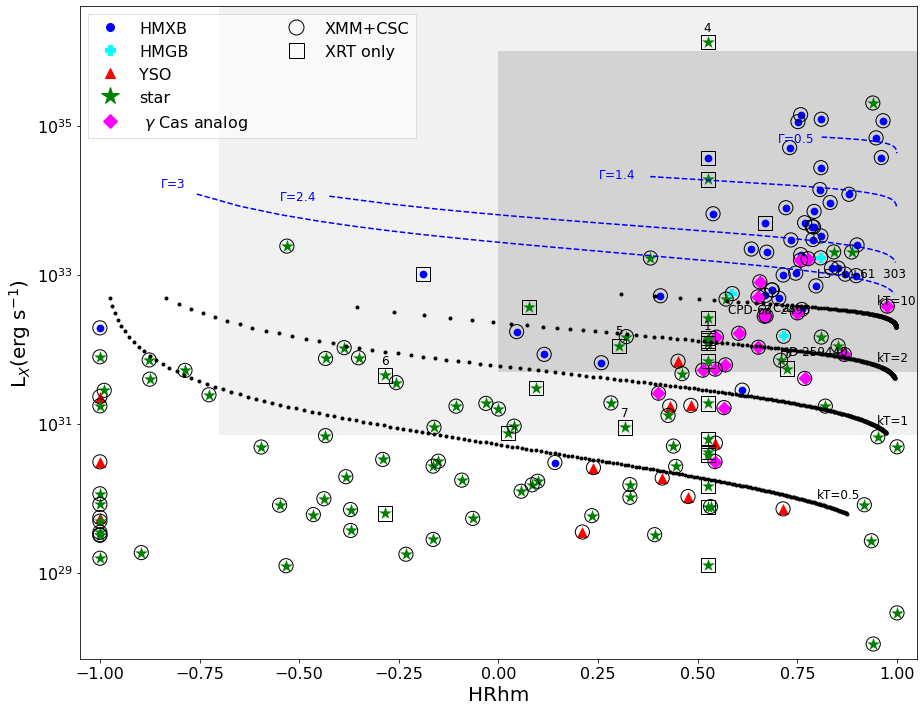

In [60]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,5e31),2.2,1e36, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=1))

ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2.2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))

for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
    
    for par in pars:
        df = pd.read_csv('models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        if model == 'pl':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 * 20,line, color=color, label=model)
        elif model == 'gas':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 /5e3,line, color=color, label=model)

ax.text(0.95, 4e32, 'kT=10', fontsize=12)
ax.text(0.95, 7e31, 'kT=2', fontsize=12)
ax.text(0.95, 1e31, 'kT=1', fontsize=12)
ax.text(0.8, 1e30, 'kT=0.5', fontsize=12)

ax.text(0.7, 6e34, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(0.25, 2e34, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.55, 1e34, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.85, 1.5e34, '$\\Gamma$=3', fontsize=12, color='b')
#'''
for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HRhm", y="LX", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_h_ms','LX']])
        ax.text(master_xray.loc[i,'HRhm']-0.01, master_xray.loc[i,'LX']*0.55, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HRhm']+0.01, master_xray.loc[i,'LX']*0.65, r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    #print(i, master_xray[master_xray['main_id']==src]['HR_h_ms']-0.01)
    ax.text(master_xray.loc[master_xray['main_id']==src,'HRhm']-0.01, master_xray.loc[master_xray['main_id']==src,'LX']*1.4, str(i), fontsize=12)
    #print(i)
    

ax.set(ylim=(7e27,4e36), xlim=(-1.05,1.05),  yscale="log", xlabel=r'HRhm', ylabel=r"L$_X$(erg s$^{-1}$)")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]
               
                
legend = ax.legend(handles=legend_elements1+legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#legend = ax.legend(handles=legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#'''

#fig.savefig("plots/LX_vs_HR_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

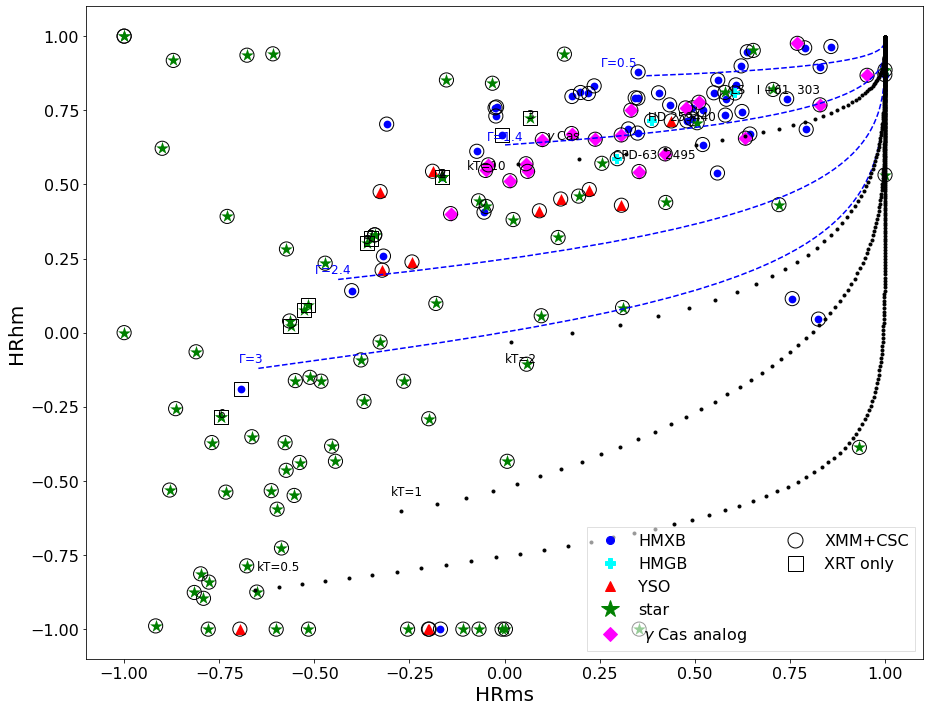

In [61]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
   
    for par in pars:
        df = pd.read_csv('models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        ax.plot( (df['f2']-df['f1'])/(df['f2']+df['f1']), (df['f3']-df['f2'])/(df['f3']+df['f2']),line, color=color)
                   

ax.text(-0.1, 0.55, 'kT=10', fontsize=12)
ax.text(0., -0.1, 'kT=2', fontsize=12)
ax.text(-0.3, -0.55, 'kT=1', fontsize=12)
ax.text(-0.65, -0.8, 'kT=0.5', fontsize=12)

ax.text(0.25, 0.9, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(-0.05, 0.65, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.5, 0.2, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.7, -0.1, '$\\Gamma$=3', fontsize=12, color='b')

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HRms", y="HRhm", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRms"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRms"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HRhm"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HRms']-0.01, master_xray.loc[i,'HRhm'], master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HRms']+0.01, master_xray.loc[i,'HRhm'], r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    ax.text(master_xray.loc[master_xray['main_id']==src,'HRms']-0.01, master_xray.loc[master_xray['main_id']==src,'HRhm'], str(i), fontsize=12)
    #print(i)
    
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]

legend = ax.legend(handles=legend_elements1+legend_elements2, loc='lower right', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/HR1_vs_HR2_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

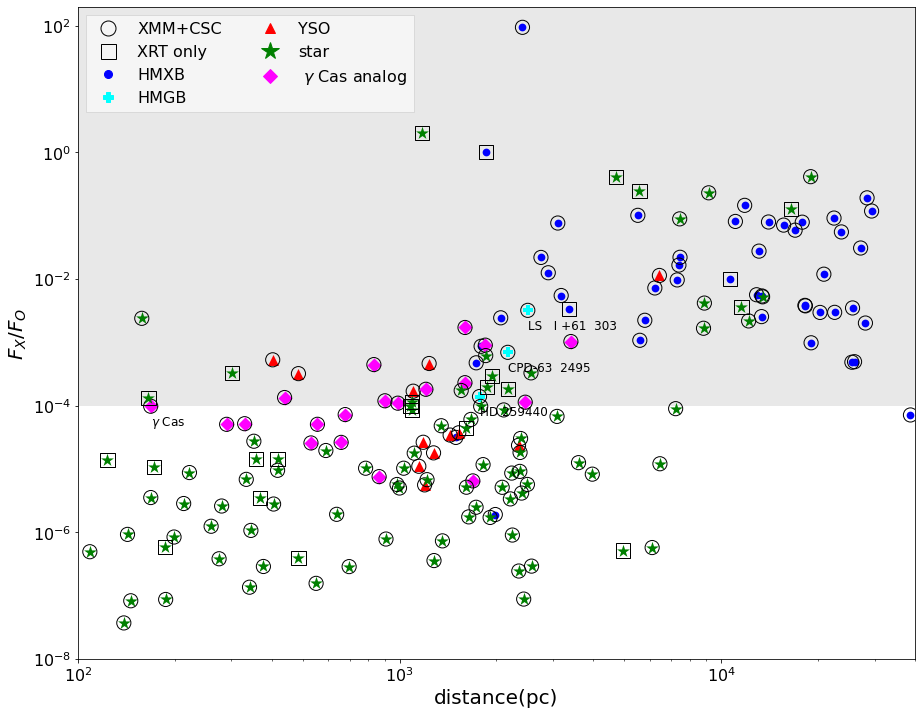

In [62]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="dist", y="fX2O", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'fX2O']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'fX2O']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(100,40000), xscale="log", yscale="log", xlabel='distance(pc)', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

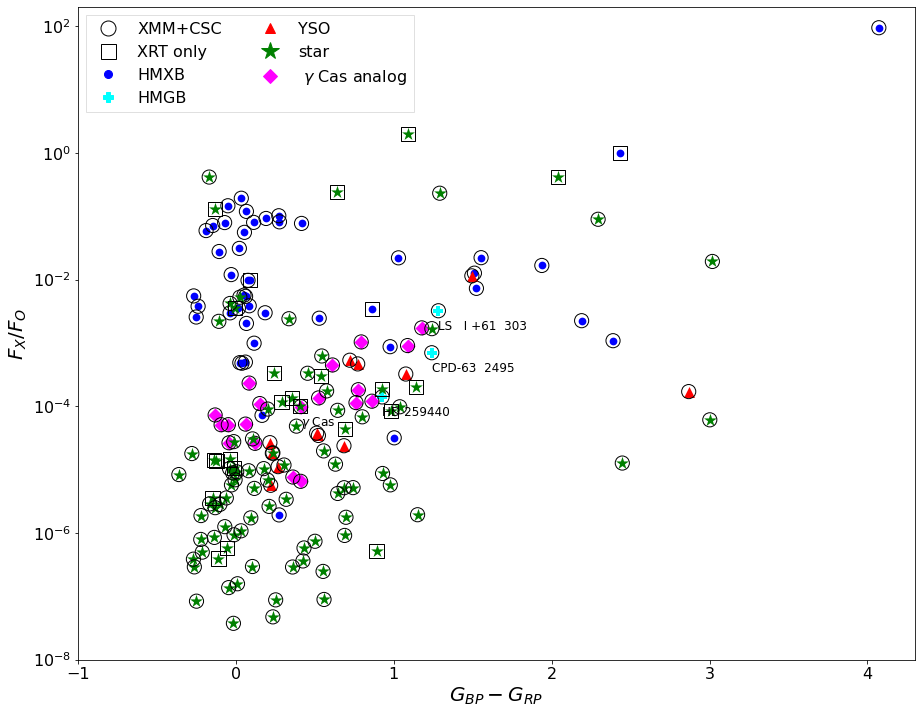

In [63]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="BP-RP", y="fX2O", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["fX2O"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'fX2O']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'fX2O']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(-1,4.3), yscale="log", xlabel=r'$G_{BP}-G_{RP}$', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

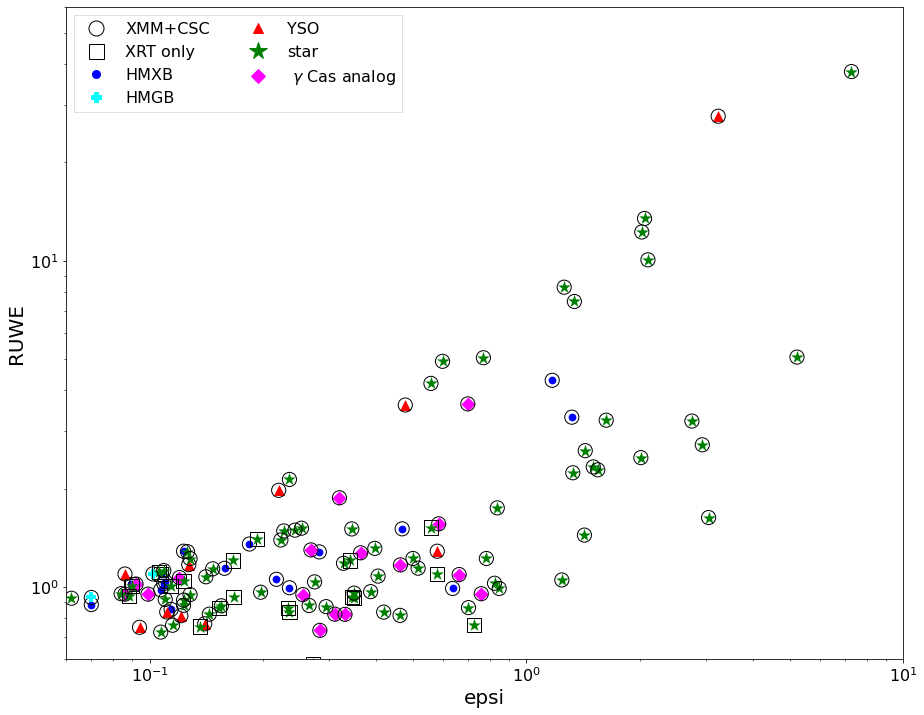

In [65]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas) & (master_xray['sepsi']>5)], x="epsi", y="RUWE", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


    
ax.set(xlim=(6e-2,10), ylim=(6e-1,60),  xscale="log", yscale="log", xlabel='epsi', ylabel="RUWE")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")